<a href="https://colab.research.google.com/github/pachterlab/Clytia_single_cell_2020/blob/master/notebooks/neuronSubpop_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Fri Aug 21 00:45:00 UTC 2020


In [ ]:
#Kallisto bus clustered starvation data, h5ad
#CHANGE TO LINK WITH cellRanger_louvain LABEL
#!wget --quiet https://caltech.box.com/shared/static/4jr6eqg6qnnrj2c8orlf7fwo7scyj6s1
#!wget --quiet https://caltech.box.com/shared/static/13jsqkczkskrf6cau9p4evhnmqyp7jn3
!wget --quiet https://caltech.box.com/shared/static/glwk0aln8a3osfuffab73a47js8n0f4w

#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing (raw)
!wget --quiet https://caltech.box.com/shared/static/3l60szs0e9hgaax4q9dbuehgoo092xww

In [ ]:
#Human ortholog annotations
!wget --quiet https://caltech.box.com/shared/static/slxs7968tths1xotumohnzwy6pgdtk6k

#Panther annotations
!wget --quiet https://caltech.box.com/shared/static/vx2iztm7tsyvg7rcj93h2w3hhjhn7jnt

#GO Terms
!wget --quiet https://caltech.box.com/shared/static/0ly6k9iwo1nc9dp5zxo8sw7qe0gt4oof

In [ ]:
#Previously saved neuron subpopulations
!wget --quiet https://caltech.box.com/shared/static/pxsxk2l24jsmsxx03nkd4isj9a2fk7ek


#Previously saved marker genes for neurons
!wget --quiet https://caltech.box.com/shared/static/4prr7ln5axj3p62fq1m592v2ro371278

#Markers for plotting on neurons
!wget --quiet https://caltech.box.com/shared/static/v8cypo9cy7k9sn2jvv4igvw9ohsuqy9l

#Markers for main figure
!wget --quiet https://caltech.box.com/shared/static/u9nysekfv5jvxwn94d0tf6h2z916i510

#Transporter XLOCs
!wget --quiet https://caltech.box.com/shared/static/vfjwgcn1l26m48x46b0tqedb8f2yiarp

#GPCR XLOCs
!wget --quiet https://caltech.box.com/shared/static/s43ehjf5wxmku2nb0ht4nraph9iye9ez

#Innexins + others
!wget --quiet https://caltech.box.com/shared/static/6husllfsr5q994sazckji5lt68oml8o2

In [ ]:
!pip install --quiet anndata
!pip install --quiet scanpy
!pip3 install --quiet leidenalg

!pip install --quiet louvain


     |████████████████████████████████| 122kB 2.7MB/s 
     |████████████████████████████████| 7.7MB 2.1MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 2.4MB 2.8MB/s 
     |████████████████████████████████| 3.2MB 31.6MB/s 
     |████████████████████████████████| 2.2MB 2.8MB/s 


In [ ]:
!pip3 install --quiet rpy2

In [ ]:
#Install Packages
import random
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

#import scrublet as scr

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")
%load_ext rpy2.ipython

In [ ]:
#Read in h5ad file
bus_fs_combo = anndata.read("glwk0aln8a3osfuffab73a47js8n0f4w")

#Previously saved neurons
neurons = anndata.read("pxsxk2l24jsmsxx03nkd4isj9a2fk7ek")

#Read in annotations
from io import StringIO

hg_ortho_df = pd.read_csv(StringIO(''.join(l.replace('|', '\t') for l in open('slxs7968tths1xotumohnzwy6pgdtk6k'))),
            sep="\t",header=None,skiprows=[0,1,2,3])

hg_ortho_df[['XLOC','TCONS']] = hg_ortho_df[13].str.split(expand=True) 
hg_ortho_df[['Gene','gi']] = hg_ortho_df[3].str.split(expand=True) 
hg_ortho_df['Description']= hg_ortho_df[11]
#hg_ortho_df.head()

panther_df = pd.read_csv('vx2iztm7tsyvg7rcj93h2w3hhjhn7jnt',
            sep="\t",header=None) #skiprows=[0,1,2,3]

#panther_df.head()

goTerm_df = pd.read_csv('0ly6k9iwo1nc9dp5zxo8sw7qe0gt4oof',
            sep=" ",header=None) #skiprows=[0,1,2,3]

#goTerm_df.head()

bus_fs_combo

AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'annos', 'new_cellRanger_louvain', 'annosSub'
    var: 'n_counts', 'mean', 'std'
    uns: 'annosSub_colors', 'annos_colors', 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', "dendrogram_['new_cellRanger_louvain']", 'dendrogram_new_cellRanger_louvain', 'fed_colors', 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'new_cellRanger_louvain_colors', 'orgID_colors', 'paga', 'pca', 'umap'
    obsm: 'X_nca', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
raw_fs_combo = anndata.read('3l60szs0e9hgaax4q9dbuehgoo092xww')

raw_fs_combo = raw_fs_combo[bus_fs_combo.obs_names,]
#Transfer info from embedded version
raw_fs_combo.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_combo.obs['cellRanger_louvain'])
raw_fs_combo.obs['fed'] = pd.Categorical(bus_fs_combo.obs['fed'])
raw_fs_combo.obsm['X_tsne'] = bus_fs_combo.obsm['X_tsne']

raw_fs_combo


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed'
    obsm: 'X_tsne'

In [ ]:
from sklearn.preprocessing import scale
def aggrModules(gene_adata, cell_raw):

  mod = np.unique(gene_adata.obs['louvain'])
  clus = np.unique(cell_raw.obs['louvain_neur'])

  aggr = pd.DataFrame(index=clus,columns=mod)
  cell_raw_copy = cell_raw.copy()

  sc.pp.normalize_per_cell(cell_raw_copy, counts_per_cell_after=1e4)
  #Go through gene modules
  for m in mod:

    mod_genes = gene_adata[gene_adata.obs['louvain'] == m ].obs_names

    #Go through cell type clusters  
    for c in clus:
      #Cell type
      sub = cell_raw_copy[cell_raw_copy.obs['louvain_neur'].isin([c])]

      sub_mod = sub[:,mod_genes]
      #sc.pp.normalize_per_cell(sub_mod, counts_per_cell_after=1e4)
      #sc.pp.log1p(sub_mod)
      sum = np.sum(sub_mod.X)

      log_sum = np.log1p(sum)

      aggr.loc[c][m] = log_sum

  #Center and scale columns (gene modules)
  aggr[aggr.columns] = scale(aggr.values)

  return aggr

###**Generating Neuron Subpopulations**

Trying to set attribute `.obs` of view, copying.


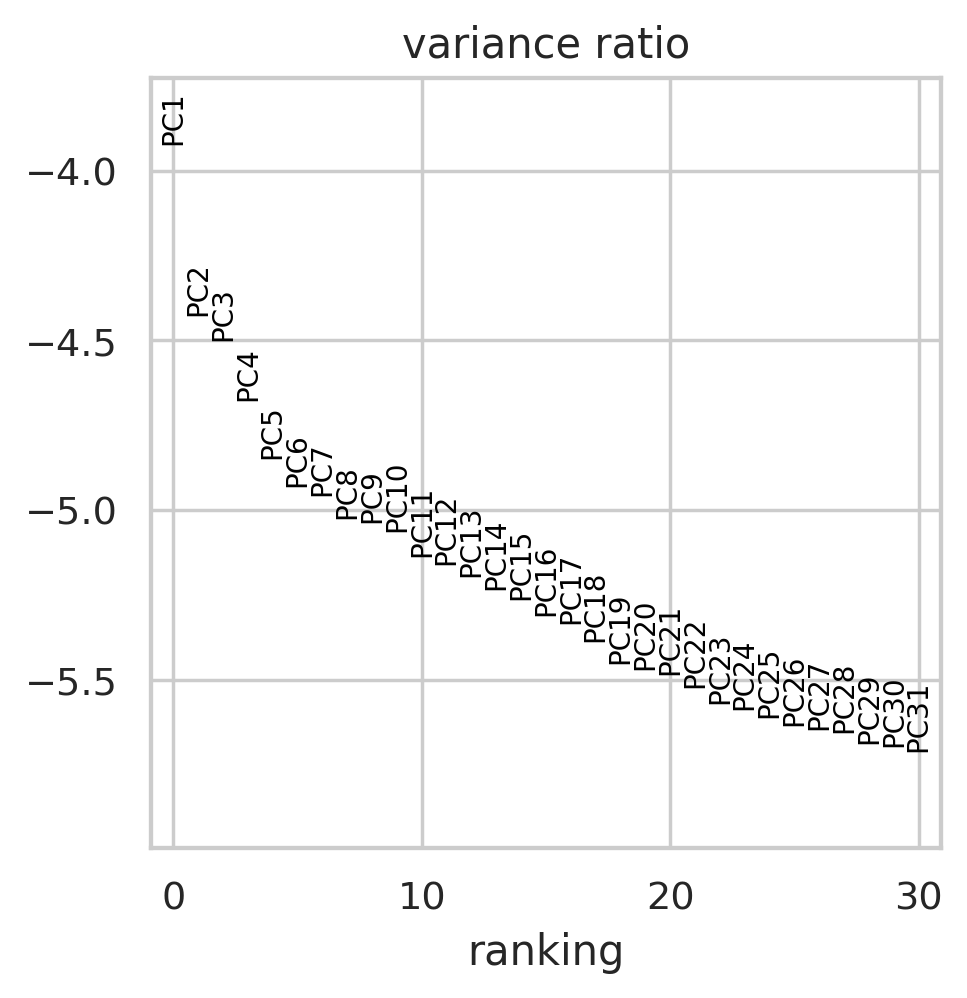

In [ ]:
# #Neurons, start from raw counts + unfiltered genes
neurons = raw_fs_combo[raw_fs_combo.obs['cellRanger_louvain'].isin([31,26,6,9])]
sc.pp.filter_cells(neurons, min_counts=0)
sc.pp.filter_genes(neurons, min_counts=0)

sc.pp.normalize_per_cell(neurons, counts_per_cell_after=1e4)

sc.pp.log1p(neurons)

# sc.pp.scale(raw_overlap_combo, max_value=10)
sc.pp.highly_variable_genes(neurons,n_top_genes=2000,n_bins=50)

#sc.pp.filter_cells(neurons, min_counts=0)
# sc.pp.filter_genes(neurons, min_counts=0)

# sc.pp.highly_variable_genes(neurons,n_top_genes=3000)
neurons = neurons[:,neurons.var['highly_variable']]

sc.pp.scale(neurons, max_value=10)

sc.tl.pca(neurons, n_comps=60)
sc.pl.pca_variance_ratio(neurons, log=True)

#applyNCAEmbed(neurons,neurons.obs['knn_clus'])

sc.pp.neighbors(neurons,n_neighbors=15, n_pcs=15) #n_neighbors=5, n_pcs=15,use_rep='X_nca'
sc.tl.louvain(neurons,resolution=1,key_added='louvain_neur',random_state=42)#Clustering algorithm,resolution=0.5

In [ ]:
sc.tl.louvain(neurons,resolution=2.5,key_added='louvain_neur',random_state=42)#Clustering algorithm,resolution=0.5

In [ ]:
neurons

AnnData object with n_obs × n_vars = 1387 × 2000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'n_counts', 'louvain_neur', 'test_louvain'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cellRanger_louvain_colors', 'hvg', 'louvain', 'louvain_neur_colors', 'neighbors', 'pca', 'rank_genes_groups', 'test_louvain_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

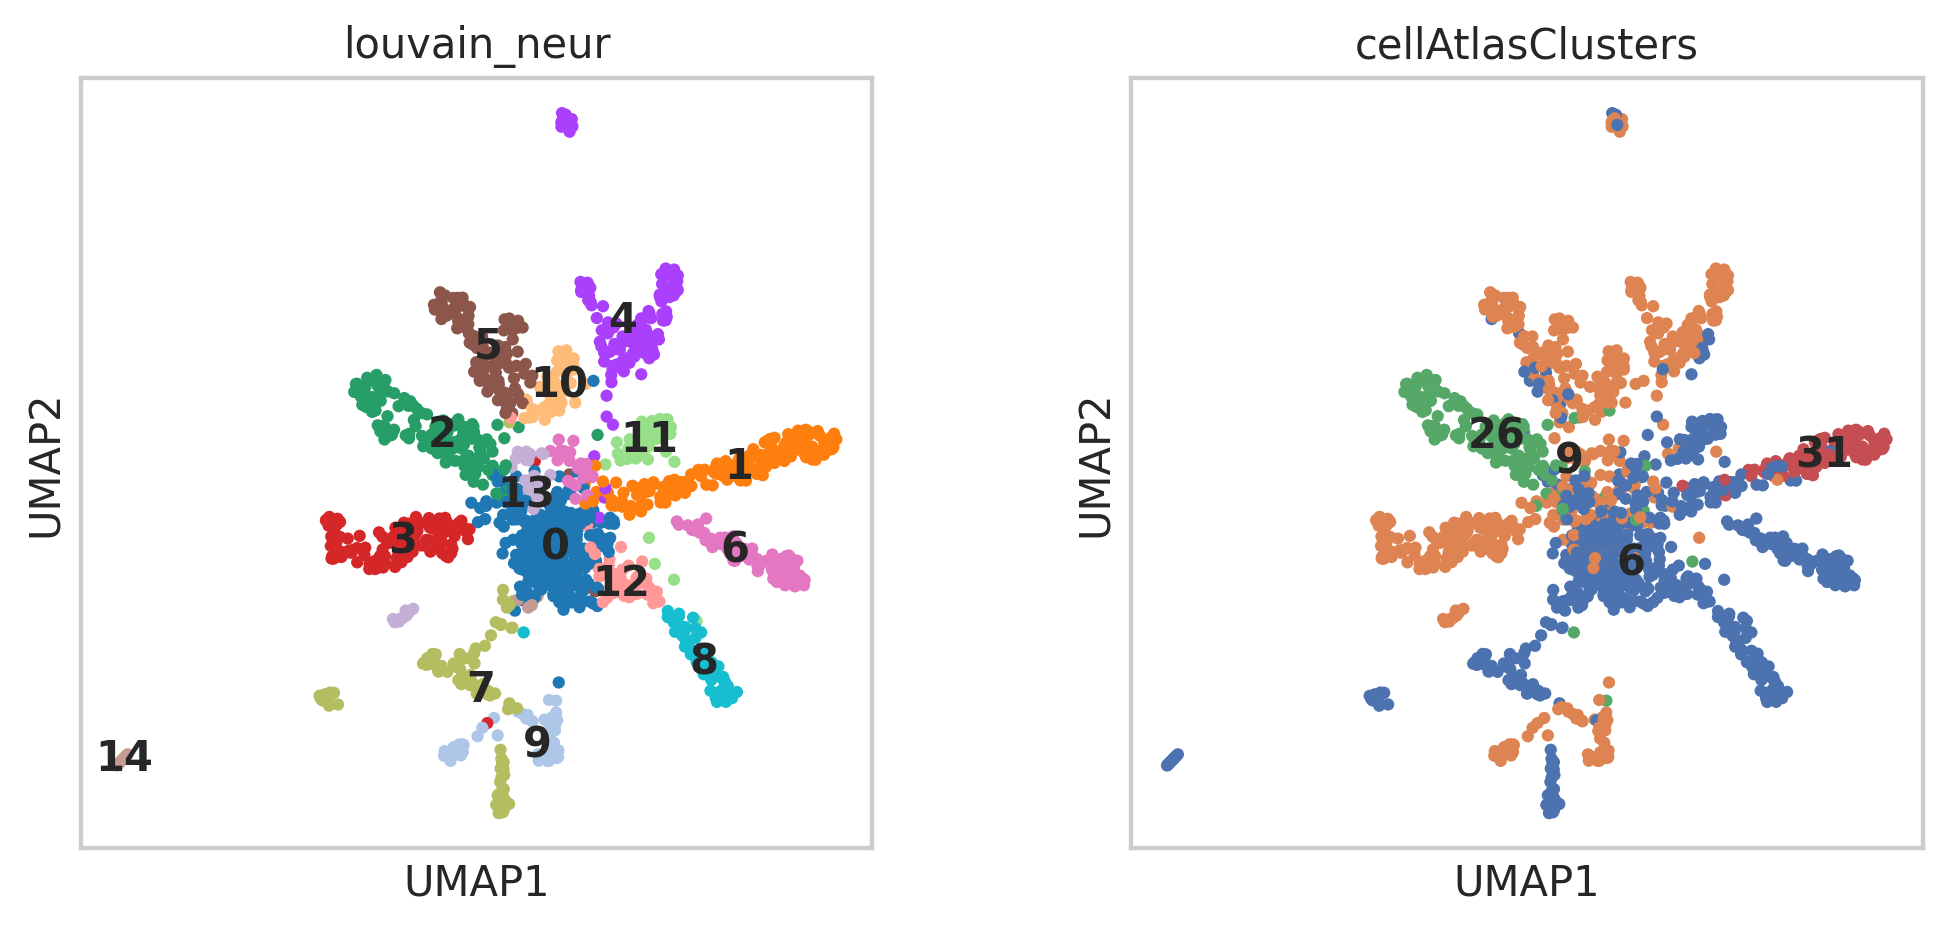

In [ ]:
sc.tl.tsne(neurons, n_pcs=15,perplexity=25,random_state = 42) #learning_rate=250
sc.tl.umap(neurons,random_state=42,spread=2.5, min_dist=1)

neurons.obs['cellAtlasClusters'] = pd.Categorical(neurons.obs['cellRanger_louvain'] )
sc.pl.umap(neurons, color=['louvain_neur','cellAtlasClusters'],color_map='viridis',size=50,legend_loc='on data')

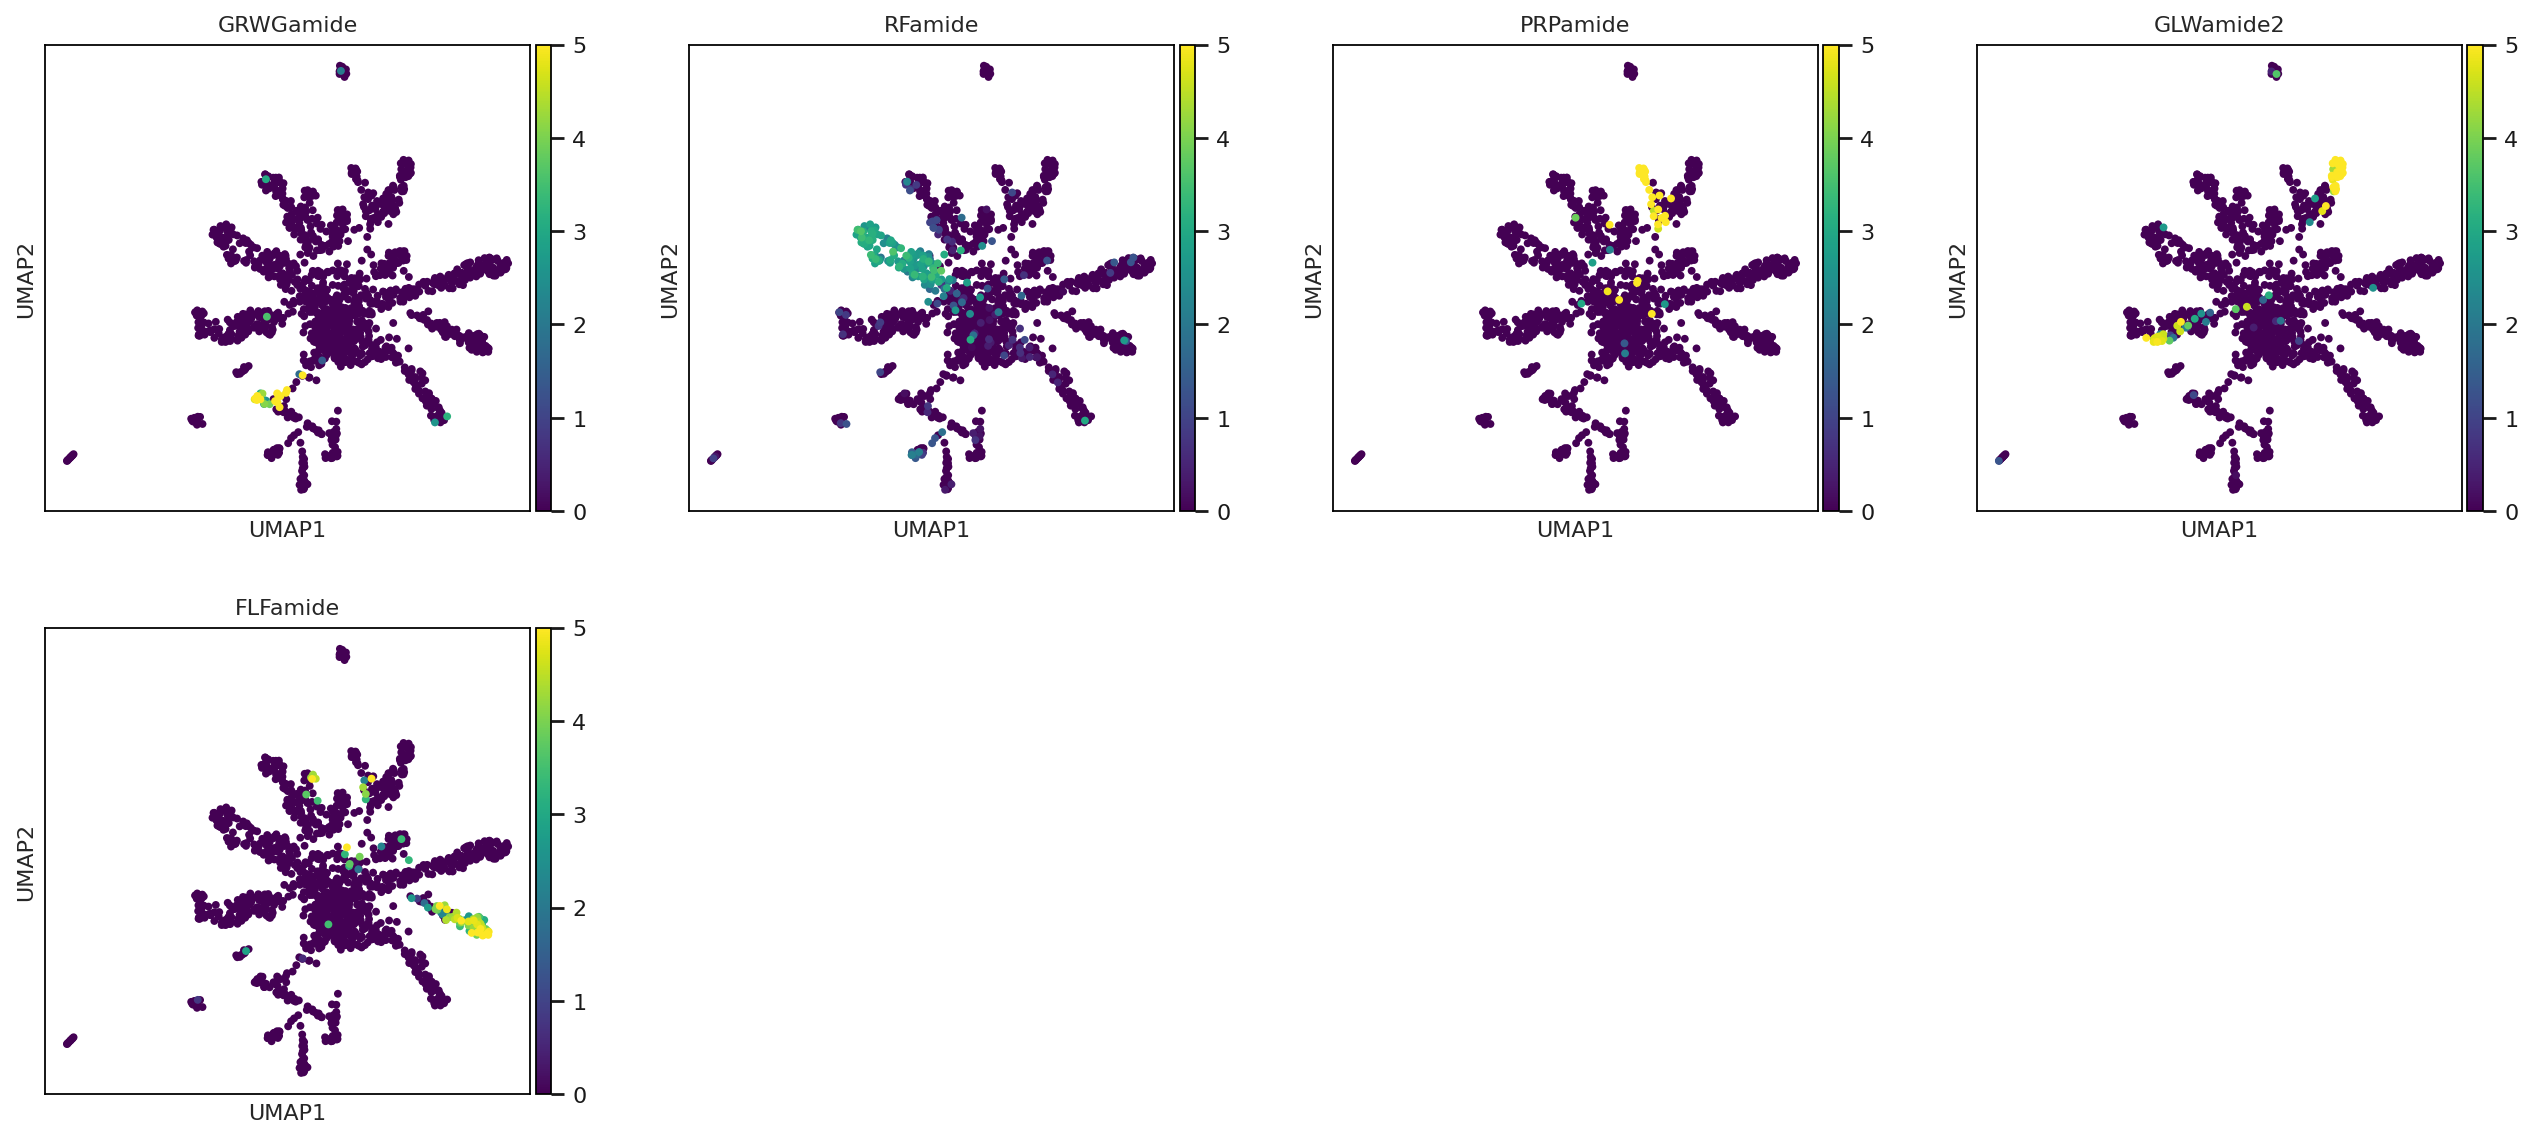

In [ ]:
sc.pl.umap(neurons, color=['XLOC_040584','XLOC_019434','TRINITY_DN20104_c0_g1_i1.mrna1','XLOC_017097',
                           'XLOC_004021'],color_map='viridis',size=50,legend_loc='on data',
           title=['GRWGamide','RFamide','PRPamide','GLWamide2',
                  'FLFamide'],vmin=0,vmax=5)




In [ ]:
#Get top n marker genes for each cluster

#Keep top 100 genes, 'louvain_neur' is label for neuron clusters determined using Louvain clustering algorithm
sc.tl.rank_genes_groups(neurons, 'louvain_neur',n_genes = 100,method='wilcoxon') #Using non-parametric test for significance
neurons

AnnData object with n_obs × n_vars = 1387 × 2000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'n_counts', 'louvain_neur', 'test_louvain'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cellRanger_louvain_colors', 'hvg', 'louvain', 'louvain_neur_colors', 'neighbors', 'pca', 'rank_genes_groups', 'test_louvain_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
# #Plot markers
# markers = []
# titles = []
# for i in np.unique(neurons.obs['louvain_neur']):
#      markers += list(neurons.uns['rank_genes_groups']['names'][str(i)][0:2])
#      titles += [markers[0]+': '+str(i),markers[1]+': '+str(i)]

# sc.pl.tsne(neurons,color=markers,color_map = 'viridis',title=titles,size = 80)

In [ ]:
#Make dataframe, with 100 marker genes for each cluster + annotations
neuron_clusters = np.unique(neurons.obs['louvain_neur'])
neuron_markers = pd.DataFrame()

neurClus = []
markerGene = []
padj = []
orthoGene = []
orthoDescr = []

pantherNum = []
pantherDescr = []

goTerms = []

for i in neuron_clusters:
  genes = neurons.uns['rank_genes_groups']['names'][str(i)]

  neurClus += list(np.repeat(i,len(genes)))
  markerGene += list(genes)
  padj += list(neurons.uns['rank_genes_groups']['pvals_adj'][str(i)])

  for g in genes:
        
    sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
    panth_df = panther_df[panther_df[0].isin([g])]
    go_df = goTerm_df[goTerm_df[0].isin([g])]

    if len(sub_df) > 0:
      #Save first result for gene/description
      orthoGene += [list(sub_df.Gene)[0]]
      orthoDescr += [list(sub_df.Description)[0]]
    else:
      orthoGene += ['NA']
      orthoDescr += ['NA']


    if len(panth_df) > 0:
      pantherNum += [list(panth_df[1])]
      pantherDescr += [list(panth_df[2])]
    else:
      pantherNum += ['NA']
      pantherDescr += ['NA']


    if len(go_df) > 0:
      goTerms += [list(go_df[1])]
    else:
      goTerms += ['NA']
 

neuron_markers['neurClus'] = neurClus
neuron_markers['markerGene'] = markerGene
neuron_markers['padj'] = padj

neuron_markers['orthoGene'] = orthoGene
neuron_markers['orthoDescr'] = orthoDescr

neuron_markers['pantherID'] = pantherNum
neuron_markers['pantherDescr'] = pantherDescr

neuron_markers['goTerms'] = goTerms
     
neuron_markers.head()
#list(neurons.uns['rank_genes_groups']['names']['1'])




,neurClus,markerGene,padj,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms
0,0,XLOC_011074,9.930711e-30,TUBA1C,tubulin alpha-1C chain isoform a [Homo sapiens],[PTHR11588:SF223],[SUBFAMILY NOT NAMED],"[GO:0045298,GO:0005856,GO:0005200,GO:0005622,G..."
1,0,XLOC_015355,2.959498e-09,NA,NA,[PTHR12124:SF53],[EXONUCLEASE 3'-5' DOMAIN-CONTAINING PROTEIN 1],"[GO:0016070,GO:0016787,GO:0016072,GO:0044238,G..."
2,0,XLOC_044603,1.123759e-05,NDUFV2,NADH dehydrogenase [ubiquinone] flavoprotein ...,[PTHR10371],[NADH DEHYDROGENASE UBIQUINONE FLAVOPROTEIN ...,"[GO:0043234,GO:0005886,GO:0016020,GO:0032991,G..."
3,0,XLOC_030920,3.931534e-05,NA,NA,[PTHR19290],[BASIC HELIX-LOOP-HELIX PROTEIN NEUROGENIN-REL...,[nan]
4,0,XLOC_004445,3.710752e-01,NA,NA,[PTHR28618],[FAMILY NOT NAMED],[nan]


In [ ]:
#Write to csv
neuron_markers.to_csv('neuron_marker_annotations.csv')

#Read in csv (previously saved version, uploaded to Box)
neuron_markers = pd.read_csv('neuron_marker_annotations.csv',
            sep=",")
neuron_markers.head()

,Unnamed: 0,neurClus,markerGene,padj,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms
0,0,0,XLOC_011074,9.930711e-30,TUBA1C,tubulin alpha-1C chain isoform a [Homo sapiens],['PTHR11588:SF223'],['SUBFAMILY NOT NAMED'],"['GO:0045298,GO:0005856,GO:0005200,GO:0005622,..."
1,1,0,XLOC_015355,2.959498e-09,NaN,NaN,['PTHR12124:SF53'],"[""EXONUCLEASE 3'-5' DOMAIN-CONTAINING PROTEIN 1""]","['GO:0016070,GO:0016787,GO:0016072,GO:0044238,..."
2,2,0,XLOC_044603,1.123759e-05,NDUFV2,NADH dehydrogenase [ubiquinone] flavoprotein ...,['PTHR10371'],['NADH DEHYDROGENASE UBIQUINONE FLAVOPROTEIN...,"['GO:0043234,GO:0005886,GO:0016020,GO:0032991,..."
3,3,0,XLOC_030920,3.931534e-05,NaN,NaN,['PTHR19290'],['BASIC HELIX-LOOP-HELIX PROTEIN NEUROGENIN-RE...,[nan]
4,4,0,XLOC_004445,3.710752e-01,NaN,NaN,['PTHR28618'],['FAMILY NOT NAMED'],[nan]


In [ ]:
# #Plot top marker gene for each cluster
# markers = []
# titles = []
# clusters = np.unique(neurons.obs['louvain_neur'])
# for i in clusters:
#   #Subset of overall dataframe
#   sub = neuron_markers[neuron_markers.neurClus.isin([i])]

#   #Rank by padj
#   sub = sub.sort_values(by='padj',ascending=True)
#   marker = list(sub.markerGene)[0]

#   markers += [marker]
#   titles += [i+': '+marker]

# sc.pl.tsne(neurons,color=markers,color_map = 'viridis',title=titles,size=80)

In [ ]:
#Plot marker gene expression for particular cluster as dotplot

#Example: Top 100 markers for cluster 1
#markers = list(neuron_markers[neuron_markers.neurClus.isin(['3'])].markerGene)
#sc.pl.dotplot(neurons, var_names=markers, groupby='louvain_neur')

In [ ]:
#Plot marker genes as heatmap
# sc.pl.heatmap(neurons, var_names=markers, groupby='louvain_neur',show_gene_labels=True)

In [ ]:
# neurons.write('neuron_subpops_fs.h5ad')

#### Look for low expression marker genes

In [ ]:
#Set threshold for expression cutoff (just using raw counts)
exprThresh = 10 # num of raw counts
percUniqThresh = 0.9

#raw_fs_combo = anndata.read('3l60szs0e9hgaax4q9dbuehgoo092xww')
neurons_raw = raw_fs_combo[raw_fs_combo.obs['cellRanger_louvain'].isin([31,26,6,9])]
neurons_raw.obs['louvain_neur'] = neurons.obs['louvain_neur']

sc.pp.filter_genes(neurons_raw, min_counts=1) #Filter for at least one count 

exprMat = neurons_raw.X.toarray()

candidates = {}
maxPercList = {}
gene_names = neurons_raw.var_names
for g in range(0,len(gene_names)):#
  #Where is expression nonzero, etc
  ind = np.where(exprMat[:,g] > exprThresh)
  #Get clusters with above thresh expression
  clusNames = pd.Series(neurons_raw.obs['louvain_neur'][ind[0]])

  #Highest percent of unique cluster counts
  normVal = clusNames.value_counts(normalize=True)
  maxPerc = np.max(normVal)
  indMax = np.argmax(normVal)
  if maxPerc >= percUniqThresh:
    candidates[gene_names[g]] = normVal.index[indMax] #Save which cluster had expression
    maxPercList[gene_names[g]] = maxPerc

print(len(candidates))



Trying to set attribute `.obs` of view, copying.


441


In [ ]:
#Make dataframe, with 100 marker genes for each cluster + annotations
lowExpr_markers = pd.DataFrame()

markerGene = []
orthoGene = []
orthoDescr = []
frac = []

pantherNum = []
pantherDescr = []

goTerms = []
clus = []


for g in candidates.keys():
        
  markerGene += [g]
  clus += [candidates[g]]
  frac += [maxPercList[g]]

  sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
  panth_df = panther_df[panther_df[0].isin([g])]
  go_df = goTerm_df[goTerm_df[0].isin([g])]

  if len(sub_df) > 0:
    #Save first result for gene/description
    orthoGene += [list(sub_df.Gene)[0]]
    orthoDescr += [list(sub_df.Description)[0]]
  else:
    orthoGene += ['NA']
    orthoDescr += ['NA']

  if len(panth_df) > 0:
    pantherNum += [list(panth_df[1])]
    pantherDescr += [list(panth_df[2])]
  else:
    pantherNum += ['NA']
    pantherDescr += ['NA']


  if len(go_df) > 0:
    goTerms += [list(go_df[1])]
  else:
    goTerms += ['NA']
  

lowExpr_markers['markerGene'] = markerGene
lowExpr_markers['clus'] = clus
lowExpr_markers['fraction'] = frac

lowExpr_markers['orthoGene'] = orthoGene
lowExpr_markers['orthoDescr'] = orthoDescr

lowExpr_markers['pantherID'] = pantherNum
lowExpr_markers['pantherDescr'] = pantherDescr

lowExpr_markers['goTerms'] = goTerms
      
lowExpr_markers.head()
  #list(neurons.uns['rank_genes_groups']['names']['1'])




,markerGene,clus,fraction,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms
0,XLOC_000004,7,1.0,LIPA,lysosomal acid lipase/cholesteryl ester hydro...,[PTHR11005:SF53],[LIPASE],"[GO:0016787,GO:0006629,GO:0044238,GO:0016788,G..."
1,XLOC_000093,4,1.0,NA,NA,NA,NA,[nan]
2,XLOC_000129,7,1.0,NA,NA,[PTHR13723:SF219],[A DISINTEGRIN AND METALLOPROTEINASE WITH THRO...,"[GO:0016337,GO:0008152,GO:0031012,GO:0007160,G..."
3,XLOC_000345,7,1.0,NA,NA,[PTHR28586],[FAMILY NOT NAMED],[nan]
4,TRINITY_DN8251_c1_g1_i1.mrna1,0,1.0,NA,NA,NA,NA,NA


In [ ]:
#lowExpr_markers.to_csv('lowExprMarkers_neurons.csv')

In [ ]:
#neuron_markers = pd.read_csv('4prr7ln5axj3p62fq1m592v2ro371278') #CHANGE
#neuron_markers.head()

overlap = list(set(neuron_markers.markerGene[neuron_markers.padj<0.05]).intersection(lowExpr_markers.markerGene))

In [ ]:
lowExpr_markers = lowExpr_markers[~lowExpr_markers.markerGene.isin(overlap)]
lowExpr_markers.head()

,markerGene,clus,fraction,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms
0,XLOC_000004,7,1.0,LIPA,lysosomal acid lipase/cholesteryl ester hydro...,[PTHR11005:SF53],[LIPASE],"[GO:0016787,GO:0006629,GO:0044238,GO:0016788,G..."
1,XLOC_000093,4,1.0,NA,NA,NA,NA,[nan]
2,XLOC_000129,7,1.0,NA,NA,[PTHR13723:SF219],[A DISINTEGRIN AND METALLOPROTEINASE WITH THRO...,"[GO:0016337,GO:0008152,GO:0031012,GO:0007160,G..."
3,XLOC_000345,7,1.0,NA,NA,[PTHR28586],[FAMILY NOT NAMED],[nan]
4,TRINITY_DN8251_c1_g1_i1.mrna1,0,1.0,NA,NA,NA,NA,NA


In [ ]:
lowExpr_markers.to_csv('lowExprMarkers_neurons.csv')

###**DESeq2 Analysis Between Fed and Starved Cells**

In [ ]:
#Remove clusters with < 5 cells per condition
bus_fs_raw = anndata.read("3l60szs0e9hgaax4q9dbuehgoo092xww")

bus_fs_raw = bus_fs_raw[neurons.obs_names,]
#bus_fs_raw.obs['orgID'] = bus_fs_clus.obs['orgID']
bus_fs_raw.obs['fed'] = neurons.obs['fed']
bus_fs_raw.obs['louvain_neur'] = neurons.obs['louvain_neur']
bus_fs_raw


#clusSize

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 1387 × 46716
    obs: 'batch', 'fed', 'louvain_neur'

In [ ]:
def clusToKeep(bus_fs_clus):
  keep = []
  clusSize = {}
  for i in np.unique(bus_fs_clus.obs['louvain_neur']):
      cells = bus_fs_clus[bus_fs_clus.obs['louvain_neur'].isin([i])]
      fed_cells = len(cells[cells.obs['fed']==True].obs_names)
      starv_cells = len(cells[cells.obs['fed']==False].obs_names)
      min_cells = np.min([fed_cells,starv_cells])
      if min_cells > 5:
        keep += [i]
        #clusSize[i] = min_cells
  return keep

#Subsample from full dataset, across each cluster
def getSampled_Cluster(bus_fs_clus,bus_fs_raw,keep):

  subSample = 100
  cellNames = np.array(bus_fs_clus.obs_names)
  fed = np.array(list(bus_fs_clus.obs['fed'] == True))
  starv = np.array(list(bus_fs_clus.obs['fed'] == False))

  allCells = []
  for i in keep:  
      cells = np.array(list(bus_fs_clus.obs['louvain_neur'].isin([i])))
      fed_cells = list(np.where(fed & cells)[0])
      starv_cells = list(np.where(starv & cells)[0])
      
      #Take all cells if < subSample
      if len(fed_cells) >= subSample:
          fed_choice = random.sample(fed_cells,subSample)
      else:
          fed_choice = fed_cells
          
      if len(starv_cells) >= subSample:
          starv_choice = random.sample(starv_cells,subSample)
      else:
          starv_choice = starv_cells
          
          
      pos = list(fed_choice)+list(starv_choice)
      allCells += list(cellNames[pos])

      
  sub_raw = bus_fs_raw[allCells,:]
  return sub_raw

#Instantiate dataframe with gene names
def makeDF_forR(sub_raw):
  fullDF = pd.DataFrame(scipy.sparse.csr_matrix.toarray(sub_raw.X).T, index = sub_raw.var_names.tolist(), columns= sub_raw.obs_names.tolist())
  conds = sub_raw.obs['fed'].tolist()
  #ids = sub_jelly4Raw.obs['orgID'].tolist()
  clus = sub_raw.obs['louvain_neur'].tolist()

  reps = np.repeat(0,len(sub_raw.obs_names))

  length = len(sub_raw[sub_raw.obs['fed'] == True].obs_names)
  reps[sub_raw.obs['fed'] == True] = range(1,length+1)

  length = len(sub_raw[sub_raw.obs['fed'] == False].obs_names)
  reps[sub_raw.obs['fed'] == False] = range(1,length+1)


  sampleDF = pd.DataFrame({'cell_ID': fullDF.columns}) \
          .assign(condition = conds) \
          .assign(replicate = reps) \
          .assign(cluster = clus) 
  sampleDF.index = sampleDF.cell_ID
  print(sampleDF.head())

  fullDF.to_csv('fullDF.csv')
  sampleDF.to_csv('sampleDF.csv')

In [ ]:
#For neuron subpopulations
#n_genes = 10000
keep = clusToKeep(neurons)
sub_raw = getSampled_Cluster(neurons,bus_fs_raw,keep)

sub_raw_copy = sub_raw.copy()
sc.pp.filter_cells(sub_raw_copy, min_counts=0)
sc.pp.filter_genes(sub_raw_copy, min_counts=1)
sc.pp.normalize_per_cell(sub_raw_copy, counts_per_cell_after=1e4)
sc.pp.log1p(sub_raw_copy)

#sc.pp.highly_variable_genes(sub_raw_copy,n_top_genes=8000)
sub_raw = sub_raw[:,sub_raw_copy.var_names] #['highly_variable']
sub_raw

View of AnnData object with n_obs × n_vars = 1287 × 18067
    obs: 'batch', 'fed', 'louvain_neur'

In [ ]:
makeDF_forR(sub_raw)

                               cell_ID  condition  replicate cluster
cell_ID                                                             
GTTCATTGTTCAACCA-2  GTTCATTGTTCAACCA-2       True          1       0
GCTCTGTCATCGGACC-2  GCTCTGTCATCGGACC-2       True          2       0
CAACCAATCTGGGCCA-2  CAACCAATCTGGGCCA-2       True          3       0
CGTGTAAAGTTGAGTA-2  CGTGTAAAGTTGAGTA-2       True          4       0
GCACATAAGCCACCTG-2  GCACATAAGCCACCTG-2       True          5       0


In [ ]:
%%R 
fullDF <- read.csv(file = 'fullDF.csv')
sampleDF <- read.csv(file = 'sampleDF.csv')
head(sampleDF)

             cell_ID          cell_ID.1 condition replicate cluster
1 GTTCATTGTTCAACCA-2 GTTCATTGTTCAACCA-2      True         1       0
2 GCTCTGTCATCGGACC-2 GCTCTGTCATCGGACC-2      True         2       0
3 CAACCAATCTGGGCCA-2 CAACCAATCTGGGCCA-2      True         3       0
4 CGTGTAAAGTTGAGTA-2 CGTGTAAAGTTGAGTA-2      True         4       0
5 GCACATAAGCCACCTG-2 GCACATAAGCCACCTG-2      True         5       0
6 GTGAAGGAGTGACATA-2 GTGAAGGAGTGACATA-2      True         6       0


In [ ]:
%%R
rownames(sampleDF) <- sampleDF$cell_ID 
#Replace '.' in cell barcodes with '-'
rownames(fullDF) <- fullDF$X
colnames(fullDF) <- gsub("\\.", "-", colnames(fullDF))
fullDF <- subset(fullDF, select = -c(X) )
head(fullDF)

sampleDF <- subset(sampleDF, select = -c(cell_ID.1) )
# head(sampleDF)
sampleDF$condition <- factor(sampleDF$condition, labels = c("starved", "fed"))

In [ ]:

%%R 
install.packages("BiocManager")
BiocManager::install(version = "3.10")


In [ ]:
#Make output directory
!mkdir kallistoDEAnalysis_Neur

!sudo apt-get update
!sudo apt-get install libxml2-dev
!sudo apt-get install r-cran-xml
!sudo apt-get install libcurl4-openssl-dev

In [ ]:
%%R 
#install.packages("DESeq2",repos = "http://cran.us.r-project.org")
BiocManager::install("DESeq2")
library('DESeq2')

In [ ]:
%%R 
#install.packages("DESeq2",repos = "http://cran.us.r-project.org")
#BiocManager::install("DESeq2")
library('DESeq2')

#library("apeglm")
#library(Rcpp)
#.libPaths()

clusters <- unique(sampleDF$cluster)
Genes <- c()
Cluster <- c()
Condition <- c() 
padj <- c()
log2FC <- c()

for (i in clusters){
 
        indices = which(sampleDF$cluster == i)
        subset = fullDF[,indices]
        subset_meta = subset(sampleDF,cluster == i)


        dds <- DESeqDataSetFromMatrix(countData = subset, colData = subset_meta, design= ~replicate + condition)

        #Set control condition
        dds$condition <- relevel(dds$condition, ref = 'fed')
        dds <- DESeq(dds,test="LRT", reduced=~replicate, sfType="poscounts", useT=TRUE, minmu=1e-6, 
                     minReplicatesForReplace=Inf,betaPrior = FALSE)#parallel = TRUE

        #Starv v Fed results
        res <- results(dds,alpha=0.05,name="condition_starved_vs_fed")
        resLFC <- res 

        resLFC <- na.omit(resLFC)
        resOrdered <- resLFC[resLFC$padj < .05,]
        #Keep log2 fold changes < -1 or > 1
        resOrdered <- resOrdered[abs(resOrdered$log2FoldChange) > 1,] 
        outcomes <- resOrdered[order(resOrdered$padj),]

        Genes <- c(Genes,row.names(outcomes))
        Cluster <- c(Cluster,rep(i,length(row.names(outcomes))))
        Condition <- c(Condition,rep('Starved',length(row.names(outcomes)))) 
        padj <- c(padj,outcomes$padj)
        log2FC <- c(log2FC,outcomes$log2FoldChange)
         
    
}

deGenesDF <- data.frame(matrix(ncol = 6, nrow = length(Genes)))
names(deGenesDF) <- c("Genes", "Cluster", "Condition","padj","padjClus","log2FC")

deGenesDF$Genes <- Genes
deGenesDF$Cluster <- Cluster
deGenesDF$Condition <- Condition
deGenesDF$padj <- padj
deGenesDF$padjClus <- padj*length(unique(Cluster))
deGenesDF$log2FC <- log2FC

write.csv(deGenesDF,'./kallistoDEAnalysis_Neur/deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample.csv')

head(deGenesDF)

R[write to console]: converting counts to integer mode

R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]:   the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was a

                          Genes Cluster Condition         padj    padjClus
1 TRINITY_DN3615_c0_g1_i2.mrna1       0   Starved 0.0002228152 0.001782522
2                   XLOC_007052       0   Starved 0.0345816141 0.276652913
3                   XLOC_014678       0   Starved 0.0345816141 0.276652913
4                   XLOC_037411       0   Starved 0.0345816141 0.276652913
5                   XLOC_045243       0   Starved 0.0477407899 0.381926319
6                   XLOC_038449       0   Starved 0.0499931597 0.399945278
      log2FC
1  -1.527334
2   1.159827
3  -1.976253
4 -18.869830
5  -1.233571
6  -1.073186


In [ ]:
%%R -w 20 -h 20 --units in -r 500
install.packages("UpSetR",repos = "http://cran.us.r-project.org")
library("UpSetR")

deGenesDF <- read.csv(file = './kallistoDEAnalysis_Neur/deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample.csv')

#Bonferronni correction across clusters
deGenesDF_toPlot = subset(deGenesDF,padjClus < .05)
#deGenesDF_toPlot = subset(deGenesDF_toPlot,abs(log2FC) > 2)

# Create empty list to store vectors
vecsToPlot <- list()

clusters = unique(deGenesDF_toPlot$Cluster)
for (i in 1:length(clusters)){
    subset = subset(deGenesDF_toPlot,Cluster == clusters[i])
    vecsToPlot[[i]] <- unique(subset$Genes)
}

names(vecsToPlot) <- clusters

upset(fromList(vecsToPlot), sets = as.character(clusters),nintersects= 500,order.by = "freq",
      mainbar.y.label='Gene Intersection Size',
     sets.x.label = 'Number of DE Genes',
     text.scale = c(1.5, 2, 1.5, 2, 1.3, 1.3))

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependency ‘plyr’


R[write to console]: trying URL 'http://cran.us.r-project.org/src/contrib/plyr_1.8.6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 401191 bytes (391 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to co

In [ ]:
deseq_df = pd.read_csv('./kallistoDEAnalysis_Neur/deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample.csv',
            sep=",")
deseq_df.head()

,Unnamed: 0,Genes,Cluster,Condition,padj,padjClus,log2FC
0,1,TRINITY_DN3615_c0_g1_i2.mrna1,0,Starved,0.000223,0.001783,-1.527334
1,2,XLOC_007052,0,Starved,0.034582,0.276653,1.159827
2,3,XLOC_014678,0,Starved,0.034582,0.276653,-1.976253
3,4,XLOC_037411,0,Starved,0.034582,0.276653,-18.869830
4,5,XLOC_045243,0,Starved,0.047741,0.381926,-1.233571


In [ ]:
orthoGene = []
orthoDescr = []

pantherNum = []
pantherDescr = []

goTerms = []

deseq_df = deseq_df[np.abs(deseq_df.log2FC) < 10]
for g in deseq_df.Genes:
        
  sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
  panth_df = panther_df[panther_df[0].isin([g])]
  go_df = goTerm_df[goTerm_df[0].isin([g])]

  if len(sub_df) > 0:
    #Save first result for gene/description
    orthoGene += [list(sub_df.Gene)[0]]
    orthoDescr += [list(sub_df.Description)[0]]
  else:
    orthoGene += ['NA']
    orthoDescr += ['NA']


  if len(panth_df) > 0:
    #Save first result for gene/description
    pantherNum += [list(panth_df[1])]
    pantherDescr += [list(panth_df[2])]
  else:
    pantherNum += ['NA']
    pantherDescr += ['NA']


  if len(go_df) > 0:
    #Save first result for gene/description
    goTerms += [list(go_df[1])]
  else:
    goTerms += ['NA']
 
deseq_df['orthoGene'] = orthoGene
deseq_df['orthoDescr'] = orthoDescr

deseq_df['pantherID'] = pantherNum
deseq_df['pantherDescr'] = pantherDescr

deseq_df['goTerms'] = goTerms
deseq_df.head()

,Unnamed: 0,Genes,Cluster,Condition,padj,padjClus,log2FC,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms
0,1,TRINITY_DN3615_c0_g1_i2.mrna1,0,Starved,0.000223,0.001783,-1.527334,NA,NA,NA,NA,NA
1,2,XLOC_007052,0,Starved,0.034582,0.276653,1.159827,CCT5,T-complex protein 1 subunit epsilon [Homo sap...,[PTHR11353:SF156],[T-COMPLEX PROTEIN 1 SUBUNIT EPSILON],"[GO:0019538,GO:0044238,GO:0006461,GO:0006457,G..."
2,3,XLOC_014678,0,Starved,0.034582,0.276653,-1.976253,NA,NA,[PTHR22884:SF402],[N-LYSINE METHYLTRANSFERASE SETD8],[nan]
4,5,XLOC_045243,0,Starved,0.047741,0.381926,-1.233571,NA,NA,[PTHR16056:SF26],[REGULATOR OF MICROTUBULE DYNAMICS PROTEIN 1],[nan]
5,6,XLOC_038449,0,Starved,0.049993,0.399945,-1.073186,NA,NA,NA,NA,NA


In [ ]:
deseq_df.to_csv('./kallistoDEAnalysis_Neur/deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample_annotations.csv')

###**Neuron Subpopulation Plots**

#### **Hierarchical Clustering of Neuron Subpopulations**

In [ ]:
#Previously saved neurons
neurons = anndata.read("pxsxk2l24jsmsxx03nkd4isj9a2fk7ek")
print(neurons)

raw_fs_combo = anndata.read('3l60szs0e9hgaax4q9dbuehgoo092xww')

raw_fs_combo = raw_fs_combo[bus_fs_combo.obs_names,]
#Transfer info from embedded version
raw_fs_combo.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_combo.obs['cellRanger_louvain'])
raw_fs_combo.obs['fed'] = pd.Categorical(bus_fs_combo.obs['fed'])
raw_fs_combo.obsm['X_tsne'] = bus_fs_combo.obsm['X_tsne']

raw_fs_combo


AnnData object with n_obs × n_vars = 1387 × 2000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'n_counts', 'louvain_neur', 'test_louvain'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cellRanger_louvain_colors', 'hvg', 'louvain', 'louvain_neur_colors', 'neighbors', 'pca', 'rank_genes_groups', 'test_louvain_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
sc.tl.dendrogram(neurons,'louvain_neur',linkage_method='ward')
neurons

AnnData object with n_obs × n_vars = 1387 × 2000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'n_counts', 'louvain_neur', 'test_louvain'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cellRanger_louvain_colors', 'hvg', 'louvain', 'louvain_neur_colors', 'neighbors', 'pca', 'rank_genes_groups', 'test_louvain_colors', 'umap', "dendrogram_['louvain_neur']"
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
neurons.uns['dendrogram_louvain_neur'] = neurons.uns["dendrogram_['louvain_neur']"]

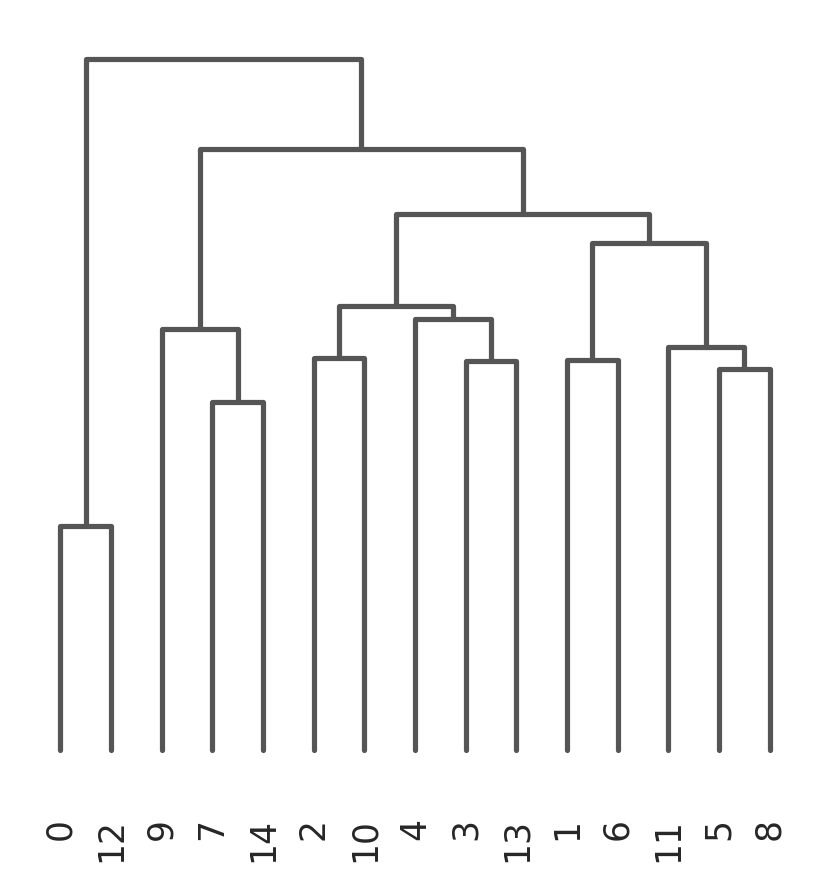

In [ ]:
sc.pl.dendrogram(neurons,'louvain_neur')

####**Plot marker genes**

In [ ]:
neuron_markers = pd.read_csv('4prr7ln5axj3p62fq1m592v2ro371278') #CHANGE
neuron_markers.head()



,Unnamed: 0,neurClus,markerGene,padj,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms
0,0,0,XLOC_011074,9.930711e-30,TUBA1C,tubulin alpha-1C chain isoform a [Homo sapiens],['PTHR11588:SF223'],['SUBFAMILY NOT NAMED'],"['GO:0045298,GO:0005856,GO:0005200,GO:0005622,..."
1,1,0,XLOC_015355,2.959498e-09,NaN,NaN,['PTHR12124:SF53'],"[""EXONUCLEASE 3'-5' DOMAIN-CONTAINING PROTEIN 1""]","['GO:0016070,GO:0016787,GO:0016072,GO:0044238,..."
2,2,0,XLOC_044603,1.123759e-05,NDUFV2,NADH dehydrogenase [ubiquinone] flavoprotein ...,['PTHR10371'],['NADH DEHYDROGENASE UBIQUINONE FLAVOPROTEIN...,"['GO:0043234,GO:0005886,GO:0016020,GO:0032991,..."
3,3,0,XLOC_030920,3.931534e-05,NaN,NaN,['PTHR19290'],['BASIC HELIX-LOOP-HELIX PROTEIN NEUROGENIN-RE...,[nan]
4,4,0,XLOC_004445,3.710752e-01,NaN,NaN,['PTHR28618'],['FAMILY NOT NAMED'],[nan]


In [ ]:
topGenes = []
var_groups = []
var_labels = []
ind = 0
n_genes = 10
for i in np.unique(neuron_markers.neurClus):
  sub = neuron_markers[neuron_markers.neurClus == i]
  sub.sort_values(by='padj',ascending=True)

  #noDups = [i for i in sub.markerGene if i not in topGenes] #Remove duplicate genes
  topGenes += list(sub.markerGene[0:n_genes])

  var_groups += [(ind,ind+n_genes-1)]
  var_labels += [str(i)]
  ind += n_genes



In [ ]:
forBLAST = neuron_markers[neuron_markers.markerGene.isin(topGenes)]
forBLAST.to_csv('blastNeuroPop_Genes.csv')

In [ ]:
#topGenes
neurons_raw = raw_fs_combo[raw_fs_combo.obs['cellRanger_louvain'].isin([31,26,6,9])]
#neurons_raw.write('neurons_raw.h5ad')

sc.pp.filter_cells(neurons_raw, min_counts=0)
sc.pp.filter_genes(neurons_raw, min_counts=0)

sc.pp.normalize_per_cell(neurons_raw, counts_per_cell_after=1e4)

sc.pp.log1p(neurons_raw)

#sc.pp.scale(neurons_raw,max_value=10)
neurons_raw.obs['louvain_neur'] = neurons.obs['louvain_neur']
neurons_raw.obsm['X_tsne'] = neurons.obsm['X_tsne']
neurons_raw.obsm['X_umap'] = neurons.obsm['X_umap']

neurons_raw.uns['dendrogram_louvain_neur'] = neurons.uns['dendrogram_louvain_neur']
neurons_raw.uns['louvain_neur_colors'] = neurons.uns['louvain_neur_colors']


Trying to set attribute `.obs` of view, copying.


In [ ]:
# neurons_raw_sub = neurons_raw[:,np.unique(topGenes)]
# sc.pl.heatmap(neurons_raw_sub, topGenes, groupby='louvain_neur', dendrogram=True,show_gene_labels=True,
#               var_group_positions=var_groups,var_group_labels=var_labels,cmap='viridis',standard_scale='var',figsize=(30,10))


In [ ]:
# neuropeps = ['XLOC_017096','XLOC_003691','XLOC_019434','XLOC_012334','XLOC_040584','XLOC_040580',
#                   'XLOC_041442','XLOC_017097','XLOC_000626','XLOC_004021',
#                   'XLOC_003339','XLOC_030120','XLOC_040209','XLOC_038155','XLOC_010892','TRINITY_DN20104_c0_g1_i1.mrna1','TRINITY_DN13065_c0_g1_i2.mrna1',
#                   'XLOC_041402']


# neuropep_titles = ['PP2-GLWa1','PP3-VPRLa','PP5-RFa','PP6-SRLLFa','PP7-GRWGa',' PP7-GRWGa',
#                   'PP9-YFa','PP11-GLWa2','PP13','PP14-FLFa',
#                   'PP15-RRFamide','PP17','PP19','PP20',' PP21','PP1-PRPa','PP8-RPRPa',
#                   'PP9-YFa']

In [ ]:
# neuropepDict = {}
# for i in range(0,len(neuropeps)):
#   neuropepDict[neuropeps[i]] = neuropep_titles[i]



In [ ]:
# sigNeuroPeps = list(set(neuropeps).intersection(neuron_markers.markerGene[neuron_markers.padj < 0.05]))
# sigNeuroPeps

['TRINITY_DN20104_c0_g1_i1.mrna1',
 'TRINITY_DN13065_c0_g1_i2.mrna1',
 'XLOC_019434',
 'XLOC_004021',
 'XLOC_040584',
 'XLOC_030120',
 'XLOC_017097']

In [ ]:
# #Heatmap with broad markers + neuropeptides
# #cat = 'Broad'
# broadMarkDict = {'XLOC_030971':'ELAV','XLOC_001566':'Synaptotagmin','XLOC_030920':'Neurogenin'}



In [ ]:
# toAdd = ['XLOC_008730','XLOC_035224','XLOC_021799','XLOC_014624',
#          'XLOC_009018','XLOC_010341','XLOC_010446','XLOC_004445','XLOC_010668','XLOC_010752','XLOC_011074',
#          'XLOC_013836','XLOC_015355','XLOC_016040','XLOC_019433','XLOC_019703','XLOC_019854','XLOC_031271','XLOC_001856',
#          'XLOC_001932','XLOC_002774','XLOC_002941','XLOC_003165','XLOC_003595','XLOC_004586','XLOC_005663','XLOC_006433',
#          'XLOC_006648','XLOC_009449','XLOC_030794','XLOC_004465','XLOC_014438','XLOC_014915','XLOC_023189','XLOC_029146',
#          'XLOC_006056','XLOC_006386','XLOC_008327','XLOC_008588','XLOC_033853','XLOC_004602','XLOC_014656','XLOC_003367',
#          'XLOC_003576','XLOC_036988',
#          'XLOC_045557','XLOC_032444','XLOC_034121','XLOC_035680',
#          'XLOC_014409','XLOC_012286','XLOC_017097','XLOC_017320','XLOC_018990','XLOC_029942',
#          'XLOC_030120','XLOC_030186','XLOC_030467','XLOC_004021','XLOC_005322','XLOC_005853',
#          'XLOC_040234','XLOC_041680','XLOC_042126','XLOC_042192','XLOC_043394']

# descr = ['PP Candidate G[KR][KRED]','PP Candidate 2','PP Candidate 3','PP Candidate G[LI]W repeats',
#          'Calmodulin','Neuronal calc sensor','centrosomal protein - is it in the stem cell cluster?','centrosomal protein - stem cell cluster',
#          'Contactin-associated protein','zinc finger','Tubulin alpha 1A','Looks like a weird transporter maybe','piRNA biogenesis','LRR protein',
#          'Some ribosome/microtubule  binding / kinectin','mitotic spindle assembly checkpoint protein','aminopeptidase','looks like it could be a cell adhesion lookin thing',
#          'Calmodulin','Calmodulin','ARV1','adhesion GPCR','rho guanine nucleotide exchange factor 4-like /spermatogenesis-associated protein 13',
#          'zinc-finger','coadhesin-like','zinc-finger','splicing factor','glutamate--cysteine ligase catalytic subunit-like','multifunctional - protease + LDL',
#          'metalloprotease and LDL receptor stuff','zinc protease and LDL','tetraspanin','synaptonemal complex related - confusing function','Anaphase-promoting complex',
#          'sperm-associated antigen','DNA polymerase delta','mix of venoms and possibly neural-lookin genes','FK506-binding protein','ubiquitin carboxyl-terminal hydrolase 36',
#          'SLC5A7','ADRB1','CHRNA5','NOS2','KCNA6','NMDA receptor',
#          'PHD finger protein','serine/threonin kinase Nek4','unconventional myosin (neuronal functions in lit)','Ubiquitin carboxyl-t hydrolase',
#          'XLOC_014409','XLOC_012286','XLOC_017097','XLOC_017320','XLOC_018990','XLOC_029942',
#          'XLOC_030120','XLOC_030186','XLOC_030467','XLOC_004021','XLOC_005322','XLOC_005853',
#          '(coadhesin-like)3','(Neurexin)','(coadhesin-like; hemicentin-1)','(zinc finger protein)','(Calmodulin)']

In [ ]:
# allGenes = {**neuropepDict, **broadMarkDict}

# ofInterestDict = {}
# for i in range(0,len(toAdd)):
#   if toAdd[i] not in allGenes.keys():
#     ofInterestDict[toAdd[i]] = descr[i]

In [ ]:
# import csv

# with open('toAddtoNeuronPlot.csv', 'w') as f:
#     for key in ofInterestDict.keys():
#         f.write("%s,%s\n"%(key,ofInterestDict[key]))

In [ ]:

# allGenes = {**allGenes, **ofInterestDict}

# len(allGenes)

84

In [ ]:
plot_markers = pd.read_csv('v8cypo9cy7k9sn2jvv4igvw9ohsuqy9l') #All subpop markers
#plot_markers = pd.read_csv('u9nysekfv5jvxwn94d0tf6h2z916i510')
plot_markers.head()

topGenes = []
labels = []
var_groups = []
var_labels = []
ind = 0
#n_genes = 10
for i in np.unique(plot_markers.Cluster):
  sub = plot_markers[plot_markers.Cluster == i]
  
  topGenes += list(sub.XLOC)
  labels += list(sub.Annotation)
  var_groups += [(ind,ind+len(sub.XLOC)-1)]
  var_labels += [str(i)]
  ind += len(sub.XLOC)


In [ ]:
# plot_markers = pd.read_csv('u9nysekfv5jvxwn94d0tf6h2z916i510')
# topGenes =  list(plot_markers.XLOC)
# labels = list(plot_markers.Annotation)

Trying to set attribute `.var` of view, copying.
... storing 'names' as categorical


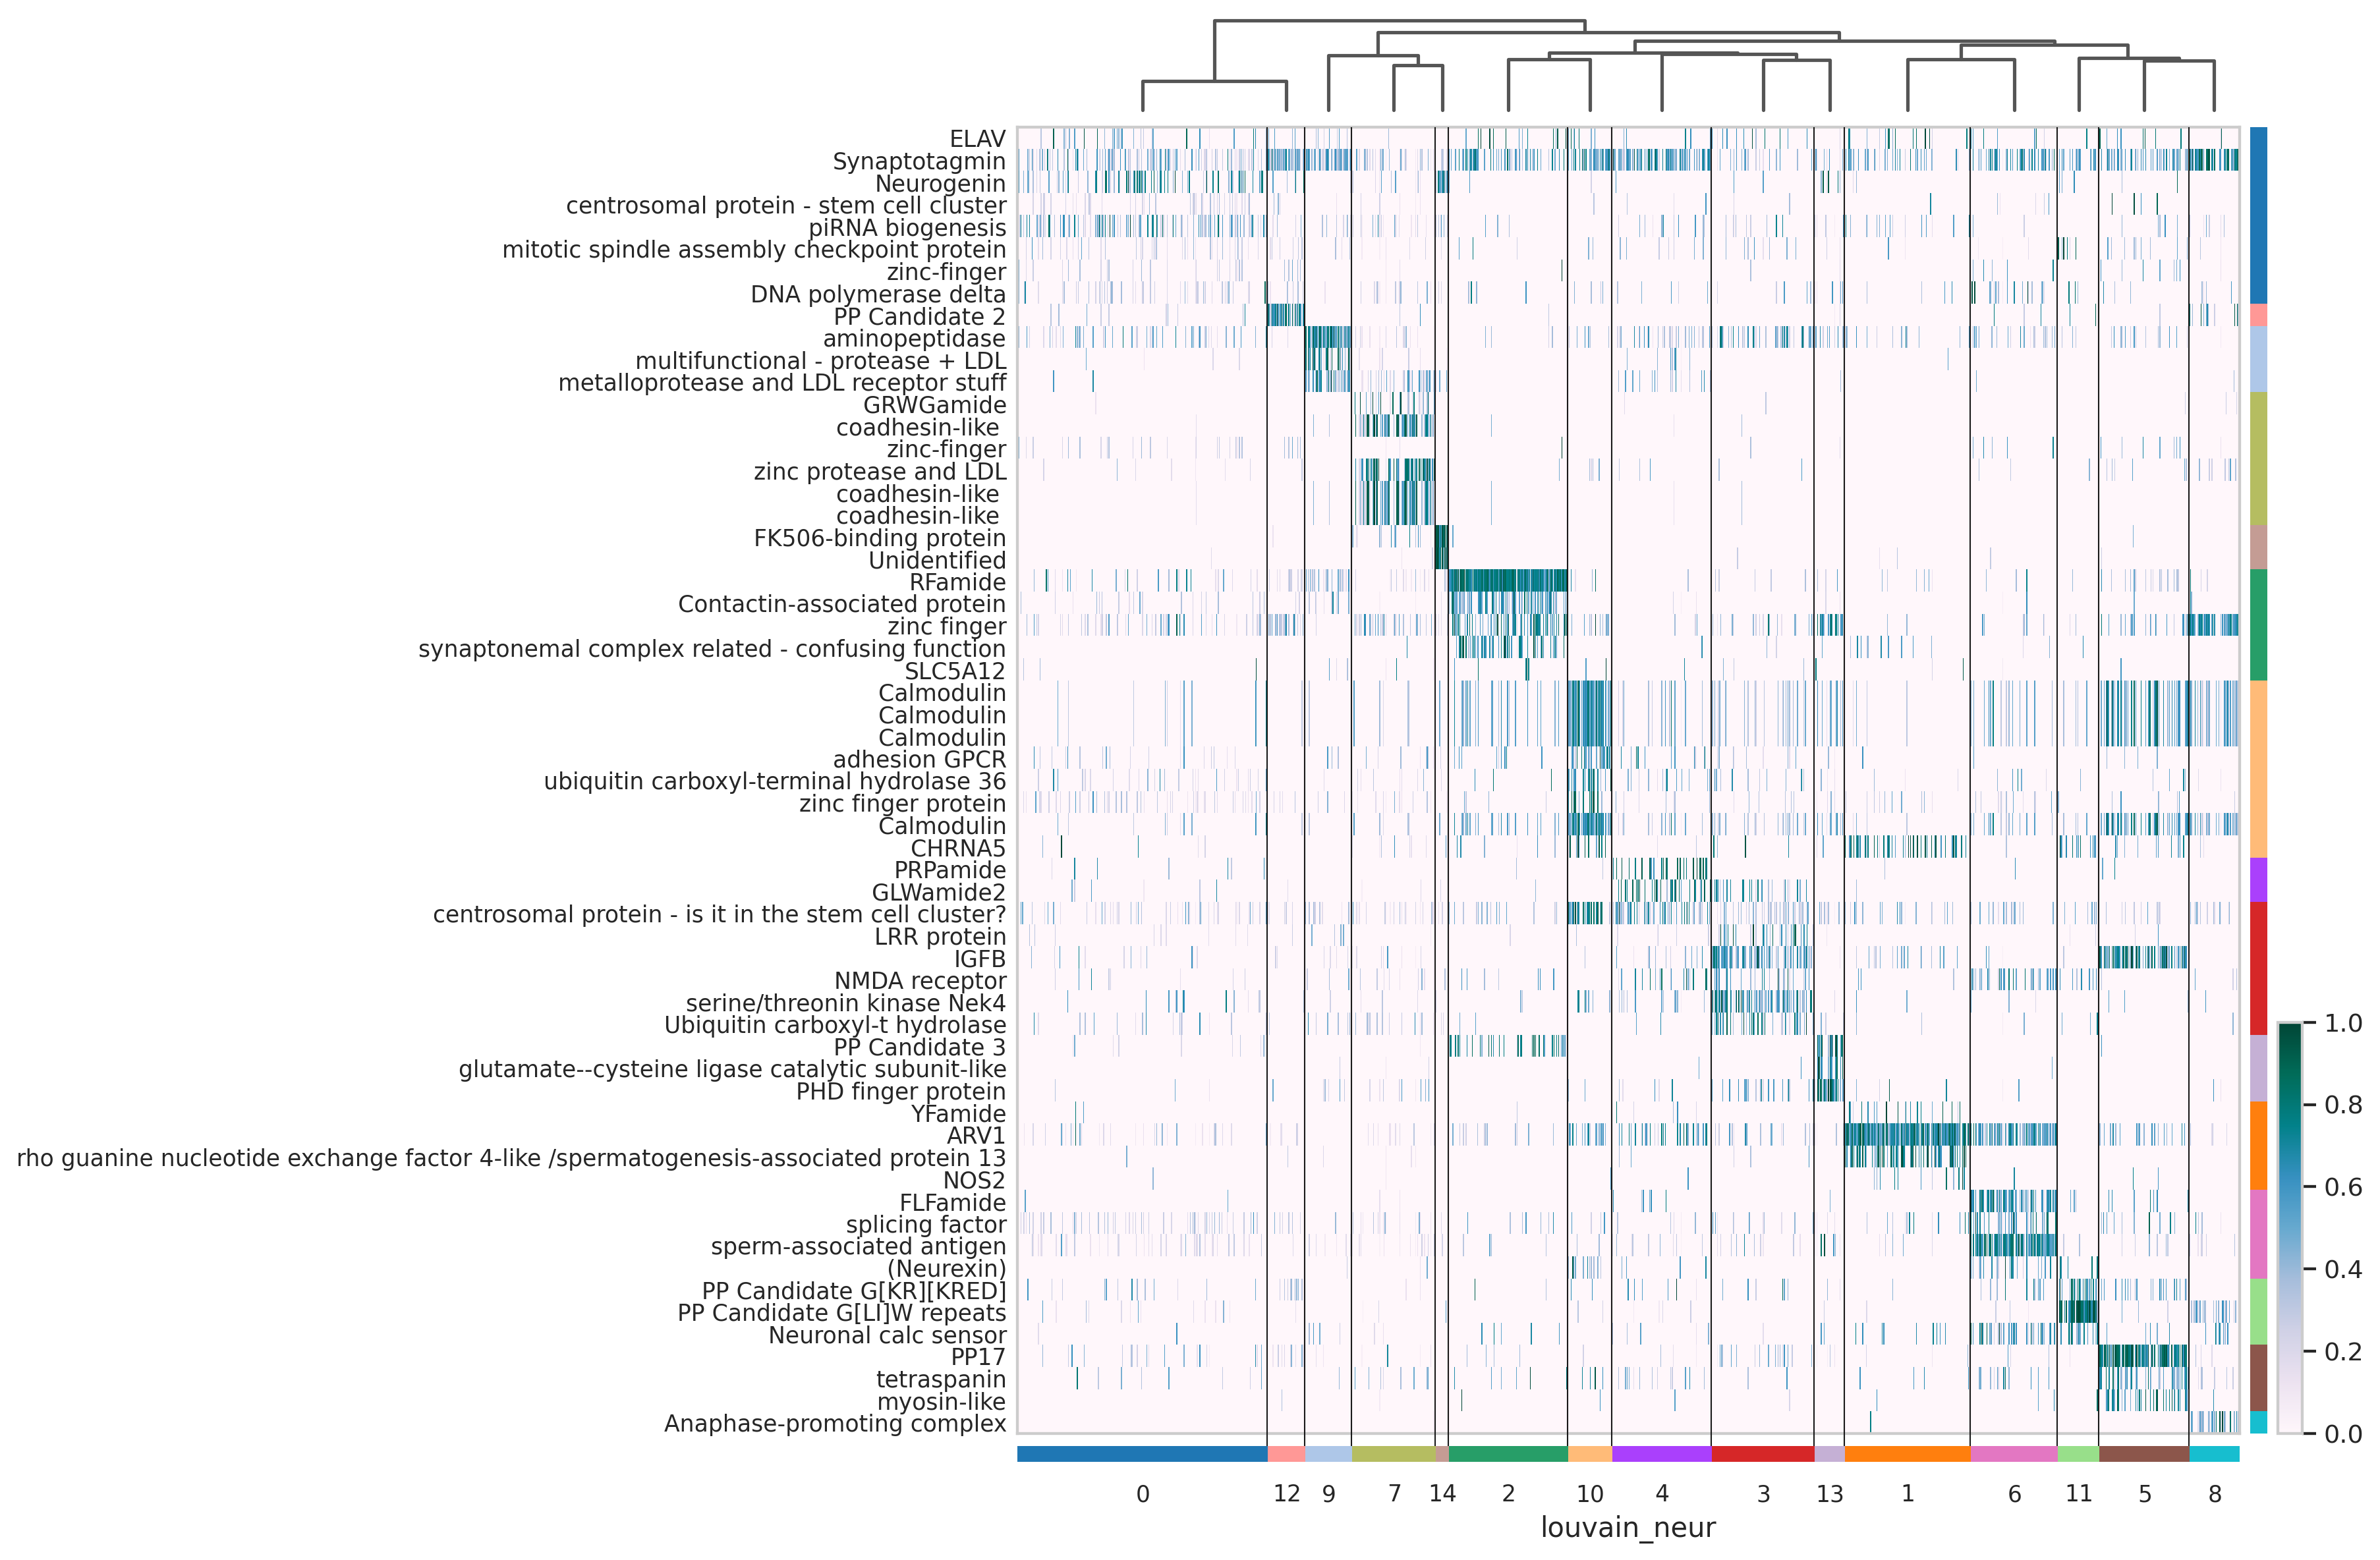

In [ ]:
#Plot particular genes in order of interest
# forPlot = ['XLOC_030971','XLOC_001566','XLOC_030920','XLOC_040584','XLOC_019434','TRINITY_DN20104_c0_g1_i1.mrna1','XLOC_017097',
#            'XLOC_041402','XLOC_004021','XLOC_030120']

# forPlot = forPlot + [i for i in toAdd if i not in forPlot]

neurons_sigTop = neurons_raw[:,topGenes]

#labels = [allGenes[i] for i in forPlot]

neurons_sigTop.var['names'] = labels
sc.pl.heatmap(neurons_sigTop, labels, groupby='louvain_neur', dendrogram=True,show_gene_labels=True,
              gene_symbols = 'names',swap_axes=True,var_group_positions =var_groups ,var_group_labels = var_labels,
              cmap='PuBuGn',standard_scale='var',save='neuronMarkers.pdf') #var_group_positions =var_groups ,var_group_labels = var_labels

Trying to set attribute `.var` of view, copying.


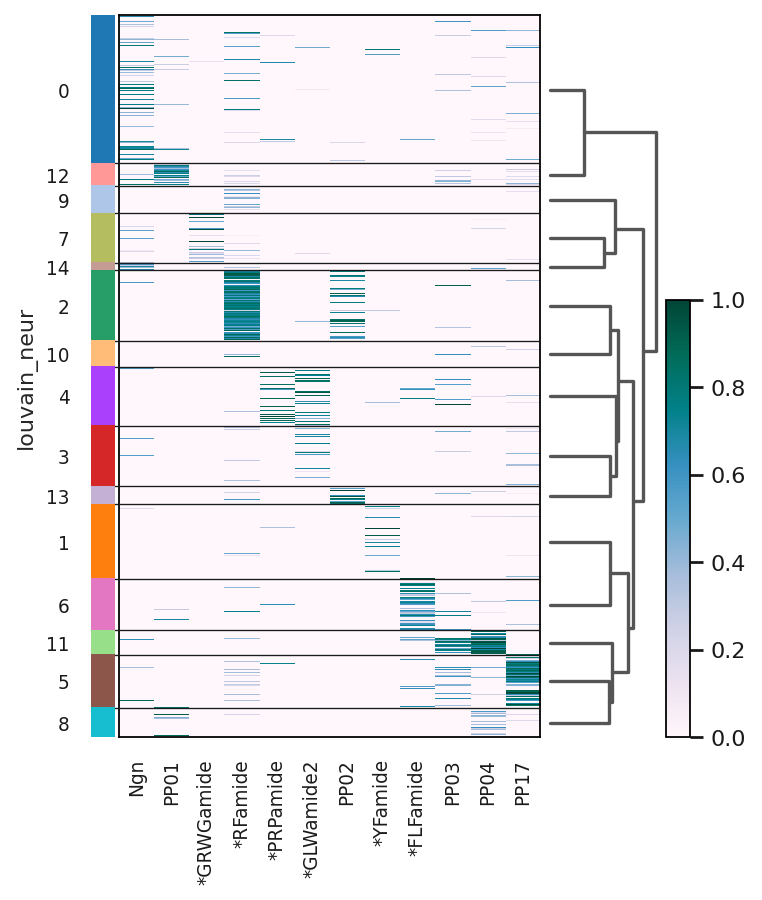

In [ ]:
#Plot particular genes in order of interest
# forPlot = ['XLOC_030971','XLOC_001566','XLOC_030920','XLOC_040584','XLOC_019434',XLOC_042761 vs'TRINITY_DN20104_c0_g1_i1.mrna1','XLOC_017097',
#            'XLOC_041402','XLOC_004021','XLOC_030120']

# forPlot = forPlot + [i for i in toAdd if i not in forPlot]
#'XLOC_030971','XLOC_003576','XLOC_001566',
#'ELAV','KCNA6','Synaptotagmin'
topGenes = ['XLOC_030920','XLOC_035224',
            'XLOC_040584','XLOC_019434','XLOC_042761','XLOC_017097',
            'XLOC_021799','XLOC_041402','XLOC_004021','XLOC_008730',
            'XLOC_014624','XLOC_030120']
neurons_sigTop = neurons_raw[:,topGenes]

#labels = [allGenes[i] for i in forPlot]
labels = ['Ngn','PP01',
          '*GRWGamide','*RFamide','*PRPamide','*GLWamide2',
          'PP02','*YFamide','*FLFamide','PP03',
          'PP04','PP17']
neurons_sigTop.var['names'] = labels

sc.set_figure_params(scanpy=True, fontsize=10)
sc.pl.heatmap(neurons_sigTop, labels, groupby='louvain_neur', dendrogram=True,show_gene_labels=True,
              gene_symbols = 'names',swap_axes=False,
              cmap='PuBuGn',standard_scale='var',save='neuronMarkers.pdf') #var_group_positions =var_groups ,var_group_labels = var_labels

In [ ]:
# noRes = ['XLOC_014409','XLOC_012286','XLOC_017097','XLOC_017320','XLOC_018990','XLOC_021799','XLOC_029942',
#          'XLOC_030120','XLOC_030186','XLOC_030467','XLOC_004021','XLOC_005322','XLOC_005853','XLOC_008730']
# neurons_notSure = neurons_raw[:,noRes]


# sc.pl.heatmap(neurons_notSure, noRes, groupby='louvain_neur', dendrogram=True,show_gene_labels=True,
#               cmap='viridis',standard_scale='var')

In [ ]:
# overlap = set(neuropeps).intersection(topGenes)
# inTop = [i for i in neuropeps if i in overlap]
# notTop = [i for i in neuropeps if i not in overlap]

In [ ]:
neurons_inTop = neurons_raw[:,inTop]
#neurons_raw.var['neuropep_names'] = neuropep_titles

In [ ]:

# sc.pl.heatmap(neurons_inTop, inTop, groupby='louvain_neur', dendrogram=True,show_gene_labels=True,
#               cmap='viridis',standard_scale ='var') #gene_symbols='neuropep_names'

In [ ]:
# neurons_notTop = neurons_raw[:,notTop]
# sc.pl.heatmap(neurons_notTop, notTop, groupby='louvain_neur', dendrogram=True,show_gene_labels=True,
#               cmap='viridis',standard_scale ='var')

In [ ]:
# set(notTop).intersection(lowExpr_markers.markerGene)

{'XLOC_038155', 'XLOC_040209', 'XLOC_040580'}

In [ ]:
# sigNeuroPeps = list(set(neuropeps).intersection(neuron_markers.markerGene[neuron_markers.padj < 0.05]))

# neurons_sigTop = neurons_raw[:,sigNeuroPeps]
# sc.pl.heatmap(neurons_sigTop, sigNeuroPeps, groupby='louvain_neur', dendrogram=True,show_gene_labels=True,
#               cmap='viridis',standard_scale ='var')

In [ ]:
# lowExpr_markers.head()

,markerGene,clus,fraction,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms
0,XLOC_000004,7,1.0,LIPA,lysosomal acid lipase/cholesteryl ester hydro...,[PTHR11005:SF53],[LIPASE],"[GO:0016787,GO:0006629,GO:0044238,GO:0016788,G..."
1,XLOC_000093,4,1.0,NA,NA,NA,NA,[nan]
2,XLOC_000129,7,1.0,NA,NA,[PTHR13723:SF219],[A DISINTEGRIN AND METALLOPROTEINASE WITH THRO...,"[GO:0016337,GO:0008152,GO:0031012,GO:0007160,G..."
3,XLOC_000345,7,1.0,NA,NA,[PTHR28586],[FAMILY NOT NAMED],[nan]
4,TRINITY_DN8251_c1_g1_i1.mrna1,0,1.0,NA,NA,NA,NA,NA


In [ ]:
# transpXLOCS = list(pd.read_csv('vfjwgcn1l26m48x46b0tqedb8f2yiarp',header=None)[0])
# inRaw = [i for i in transpXLOCS if i in list(neurons_raw.var_names)]

# toPlot = neurons_raw[:,inRaw]

In [ ]:
# sc.pl.heatmap(neurons_raw, inRaw, groupby='louvain_neur', dendrogram=True,show_gene_labels=True,
#               cmap='PuBuGn',standard_scale='var')

In [ ]:
# gpcrXLOCS = list(pd.read_csv('s43ehjf5wxmku2nb0ht4nraph9iye9ez',header=None)[0])
# inRaw = [i for i in gpcrXLOCS if i in list(neurons_raw.var_names)]

# toPlot = neurons_raw[:,inRaw]

In [ ]:
# sc.pl.heatmap(neurons_raw, inRaw, groupby='louvain_neur', dendrogram=True,show_gene_labels=True,
#               cmap='PuBuGn',standard_scale='var')

In [ ]:
# innexinXLOCS = list(pd.read_csv('6husllfsr5q994sazckji5lt68oml8o2',header=None)[0])
# inRaw = [i for i in innexinXLOCS if i in list(neurons_raw.var_names)]
# notInRaw = [i for i in innexinXLOCS if i not in list(neurons_raw.var_names)]
# print(len(inRaw)/len(innexinXLOCS))
# print(notInRaw)

# toPlot = neurons_raw[:,inRaw]

0.9210526315789473
['XLOC_010399', 'XLOC_044333', 'XLOC_000706']


In [ ]:
# sc.pl.heatmap(neurons_raw, inRaw, groupby='louvain_neur', dendrogram=True,show_gene_labels=True,
#               cmap='PuBuGn',standard_scale='var')

In [ ]:
# #'XLOC_037660' in list(bus_fs_raw.var_names)

# # 'XLOC_021850' in list(bus_fs_raw.var_names) instead of XLOC_010399

# # XLOC_037659 instead of XLOC_037660

# genes = ['XLOC_014365','XLOC_039658','XLOC_026179','XLOC_037659','XLOC_014942','XLOC_009450','XLOC_037610','XLOC_035947',
#  'XLOC_045755','XLOC_043531','XLOC_039390','XLOC_040602','XLOC_034872','XLOC_021040','XLOC_044379',
#  'XLOC_003367','XLOC_010274','XLOC_033853','XLOC_036636','XLOC_021850']

# print(len(genes))
# inRaw = [i for i in genes if i in list(neurons_raw.var_names)]
# print(len(inRaw))

20
20


In [ ]:
# toPlot = neurons_raw[:,inRaw]
# #sc.pp.log1p(toPlot)

# sc.pl.heatmap(toPlot, inRaw, groupby='louvain_neur', dendrogram=True,show_gene_labels=True,
#               cmap='PuBuGn',standard_scale='var')

In [ ]:
len(np.unique(inRaw))

34

In [ ]:
# #Add to raw data so all genes can be plotted
# raw_fs_combo.obs['new_cellRanger_louvain'] = bus_fs_combo.obs['new_cellRanger_louvain']
# raw_fs_combo.uns["dendrogram_new_cellRanger_louvain"] = bus_fs_combo.uns["dendrogram_new_cellRanger_louvain"]
# raw_fs_combo.uns['new_cellRanger_louvain_colors'] = bus_fs_combo.uns['new_cellRanger_louvain_colors']

# toPlot = raw_fs_combo.copy()
# sc.pp.log1p(toPlot)

# sc.pl.heatmap(toPlot, inRaw, groupby='new_cellRanger_louvain',dendrogram=True, show_gene_labels=True,swap_axes=True,figsize = (50,10),
#               cmap='PuBuGn',standard_scale='var')

In [ ]:
raw_fs_combo

AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed'
    obsm: 'X_tsne'

###**Gene Sets Across Neuron Subpopulations**

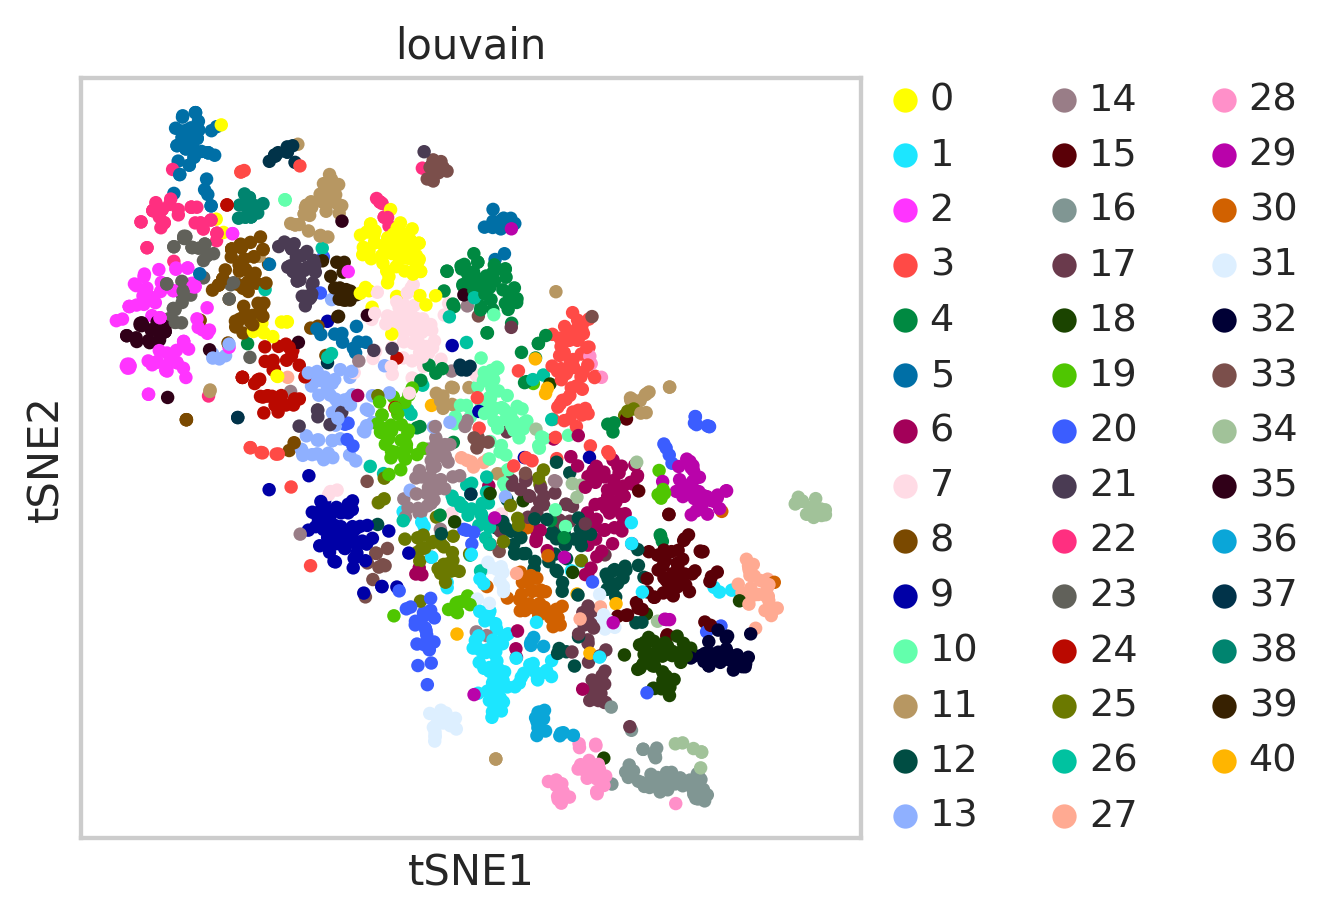

In [ ]:
de_gene_adata = anndata.AnnData(X=neurons.X.T)
de_gene_adata.var_names = neurons.obs_names
de_gene_adata.obs_names = neurons.var_names

sc.pp.scale(de_gene_adata, max_value=10)
sc.tl.pca(de_gene_adata, n_comps=60)
#sc.pl.pca_variance_ratio(bus_combo, log=True)

#Determine neighbors for clustering
sc.pp.neighbors(de_gene_adata,n_neighbors=10, n_pcs=15) #n_neighbors=5, n_pcs=15,  20, n_pcs=15
sc.tl.louvain(de_gene_adata,resolution=3.5) #2

sc.tl.tsne(de_gene_adata, n_pcs=15,random_state=42)
sc.pl.tsne(de_gene_adata,color=['louvain'])

In [ ]:
cell_raw = raw_fs_combo[neurons.obs_names,:]
cell_raw.obs['louvain_neur'] = neurons.obs['louvain_neur']
#cell_raw = raw_fs_combo[raw_fs_combo.obs['cellRanger_louvain'].isin([31,26,6,9])]

aggr = aggrModules(de_gene_adata,cell_raw)
aggr.head()

Trying to set attribute `.obs` of view, copying.


,0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,36,37,38,39,4,40,5,6,7,8,9
0,1.039733,0.723708,1.120995,0.157953,0.575273,0.982118,0.861528,0.120164,0.048447,0.187078,1.224558,0.855404,1.355408,-0.030625,0.906458,1.569233,1.531529,0.890383,0.823085,0.953714,0.534684,0.557741,0.356094,1.436921,0.635279,0.454306,0.363286,1.289845,0.843128,0.606395,0.998614,0.321423,1.783882,0.778407,0.797662,0.929359,1.343311,2.282613,0.419925,1.322405,1.297119
1,2.127768,1.177388,1.348166,-0.126805,1.047025,0.628092,1.188360,1.131071,-0.160989,0.469691,2.091963,0.764522,0.982005,0.590523,1.127369,1.701889,-0.698785,0.778692,1.092943,0.633827,0.631018,0.049474,0.233722,1.094718,0.258895,-0.167415,2.190368,1.242350,-0.083608,1.327001,0.881558,0.674899,-0.379777,0.935497,1.098689,0.891694,0.868691,0.648202,2.092263,0.378223,1.460494
10,-1.158003,-0.187977,-0.736858,-0.508121,0.218530,-1.087751,-0.238257,-0.401485,0.634764,-1.234059,0.193200,-0.661592,-0.733411,-0.570147,-1.490770,-1.011522,-0.698785,-0.144000,-0.612208,0.898669,0.487338,-0.250472,0.761994,-1.179367,1.621396,0.118224,0.396456,-1.528845,-0.350994,-0.672916,-0.595583,-0.212338,-0.379777,-1.496914,-1.758136,-0.119874,-0.041001,-0.477891,-0.308731,0.981787,-2.036978
11,0.296163,0.141189,0.282027,2.730651,0.147847,-0.588498,-0.288296,0.234740,-0.946687,-0.528813,-0.579254,0.193162,-0.733411,0.193373,0.897360,-1.011522,-0.698785,0.569661,0.747934,0.151120,-0.364230,-0.638463,0.131205,0.379612,-0.394685,-0.453389,-0.122895,-1.696489,-0.807314,-0.672916,-0.436238,0.754565,-0.379777,1.479460,0.753851,0.272441,-1.698368,-0.456045,0.553525,0.297460,-0.076737
12,-0.741591,-1.469302,-0.809884,-1.547993,-1.962351,-0.116510,-0.465885,-1.717911,-1.633981,-1.382370,-0.997977,-1.654524,-0.733411,0.758729,0.178380,-1.011522,1.352368,0.181577,-0.862869,-1.894642,-1.821788,-1.186695,-0.849116,-0.878512,-1.551566,-1.578708,-1.349890,-1.159711,-0.908714,-0.672916,-1.466794,-1.422821,-0.379777,-0.845270,-1.103207,-0.552284,-0.529078,0.110048,-0.280230,0.171972,-0.926831


Text(0.5, 0.98, 'Neuron Subpopulation Gene Sets')

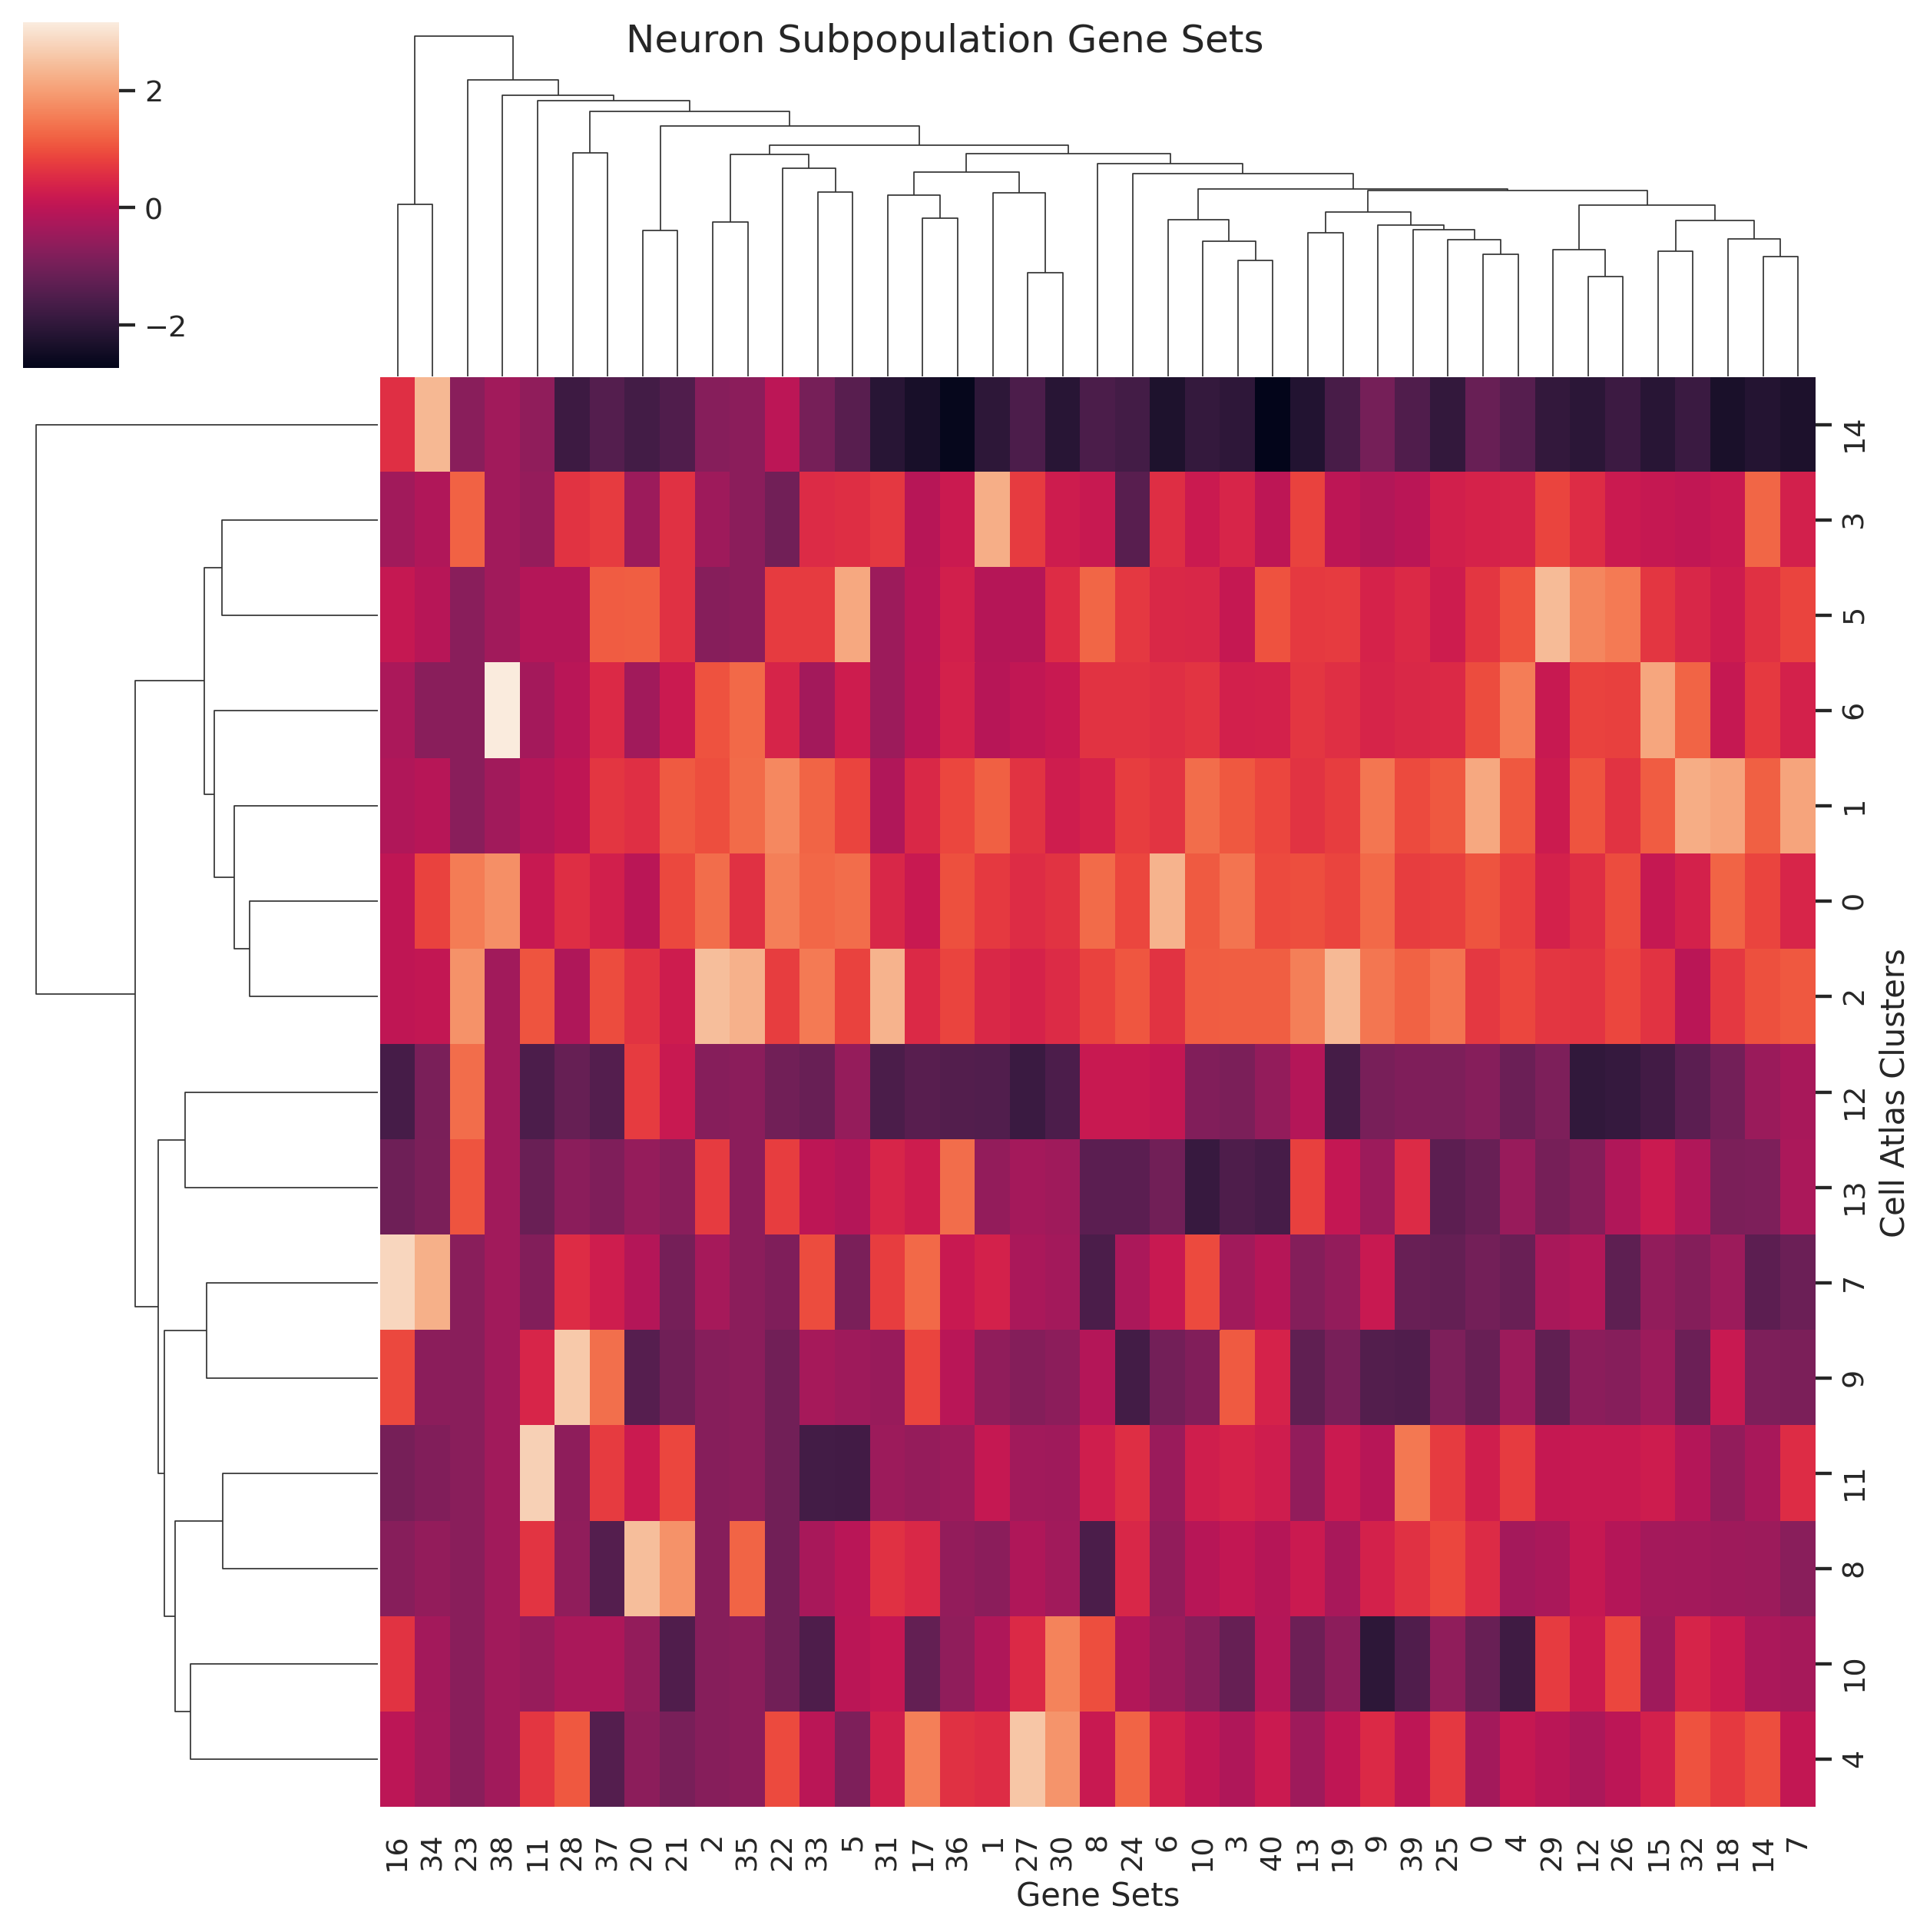

In [ ]:
fig = sns.clustermap(aggr,yticklabels=True,xticklabels=True)
fig.ax_heatmap.set_xlabel('Gene Sets')
fig.ax_heatmap.set_ylabel('Cell Atlas Clusters')
fig.fig.suptitle('Neuron Subpopulation Gene Sets')